### Time Series Anomaly Detection using ARIMA, LSTM & DBSCAN 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import DBSCAN
from datetime import datetime

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import numpy as np
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20,10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
dataset = pd.read_excel('AirQualityUCI.xlsx', parse_dates=[['Date','Time']], index_col='Date_Time')
#converting the data into a dataframe
df_data = pd.DataFrame(dataset)
df_data.head(5)

CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
Date_Time                                                                      
2004-03-10 18:00:00     2.6      1360.00       150  11.881723        1045.50   
2004-03-10 19:00:00     2.0      1292.25       112   9.397165         954.75   
2004-03-10 20:00:00     2.2      1402.00        88   8.997817         939.25   
2004-03-10 21:00:00     2.2      1375.50        80   9.228796         948.25   
2004-03-10 22:00:00     1.6      1272.25        51   6.518224         835.50   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Date_Time                                                           
2004-03-10 18:00:00    166.0       1056.25    113.0       1692.00   
2004-03-10 19:00:00    103.0       1173.75     92.0       1558.75   
2004-03-10 20:00:00    131.0       1140.00    114.0       1554.50   
2004-03-10 21:00:00    172.0       1092.00    122.0       1583.75   
2004-03-10 22:00:00    131.0       1205.00    116.0       1490.00   

                     PT08.S5(O3)      T         RH        AH  
Date_Time                                                     
2004-03-10 18:00:00      1267.50  13.60  48.875001  0.757754  
2004-03-10 19:00:00       972.25  13.30  47.700000  0.725487  
2004-03-10 20:00:00      1074.00  11.90  53.975000  0.750239  
2004-03-10 21:00:00      1203.25  11.00  60.000000  0.786713  
2004-03-10 22:00:00      1110.00  11.15  59.575001  0.788794

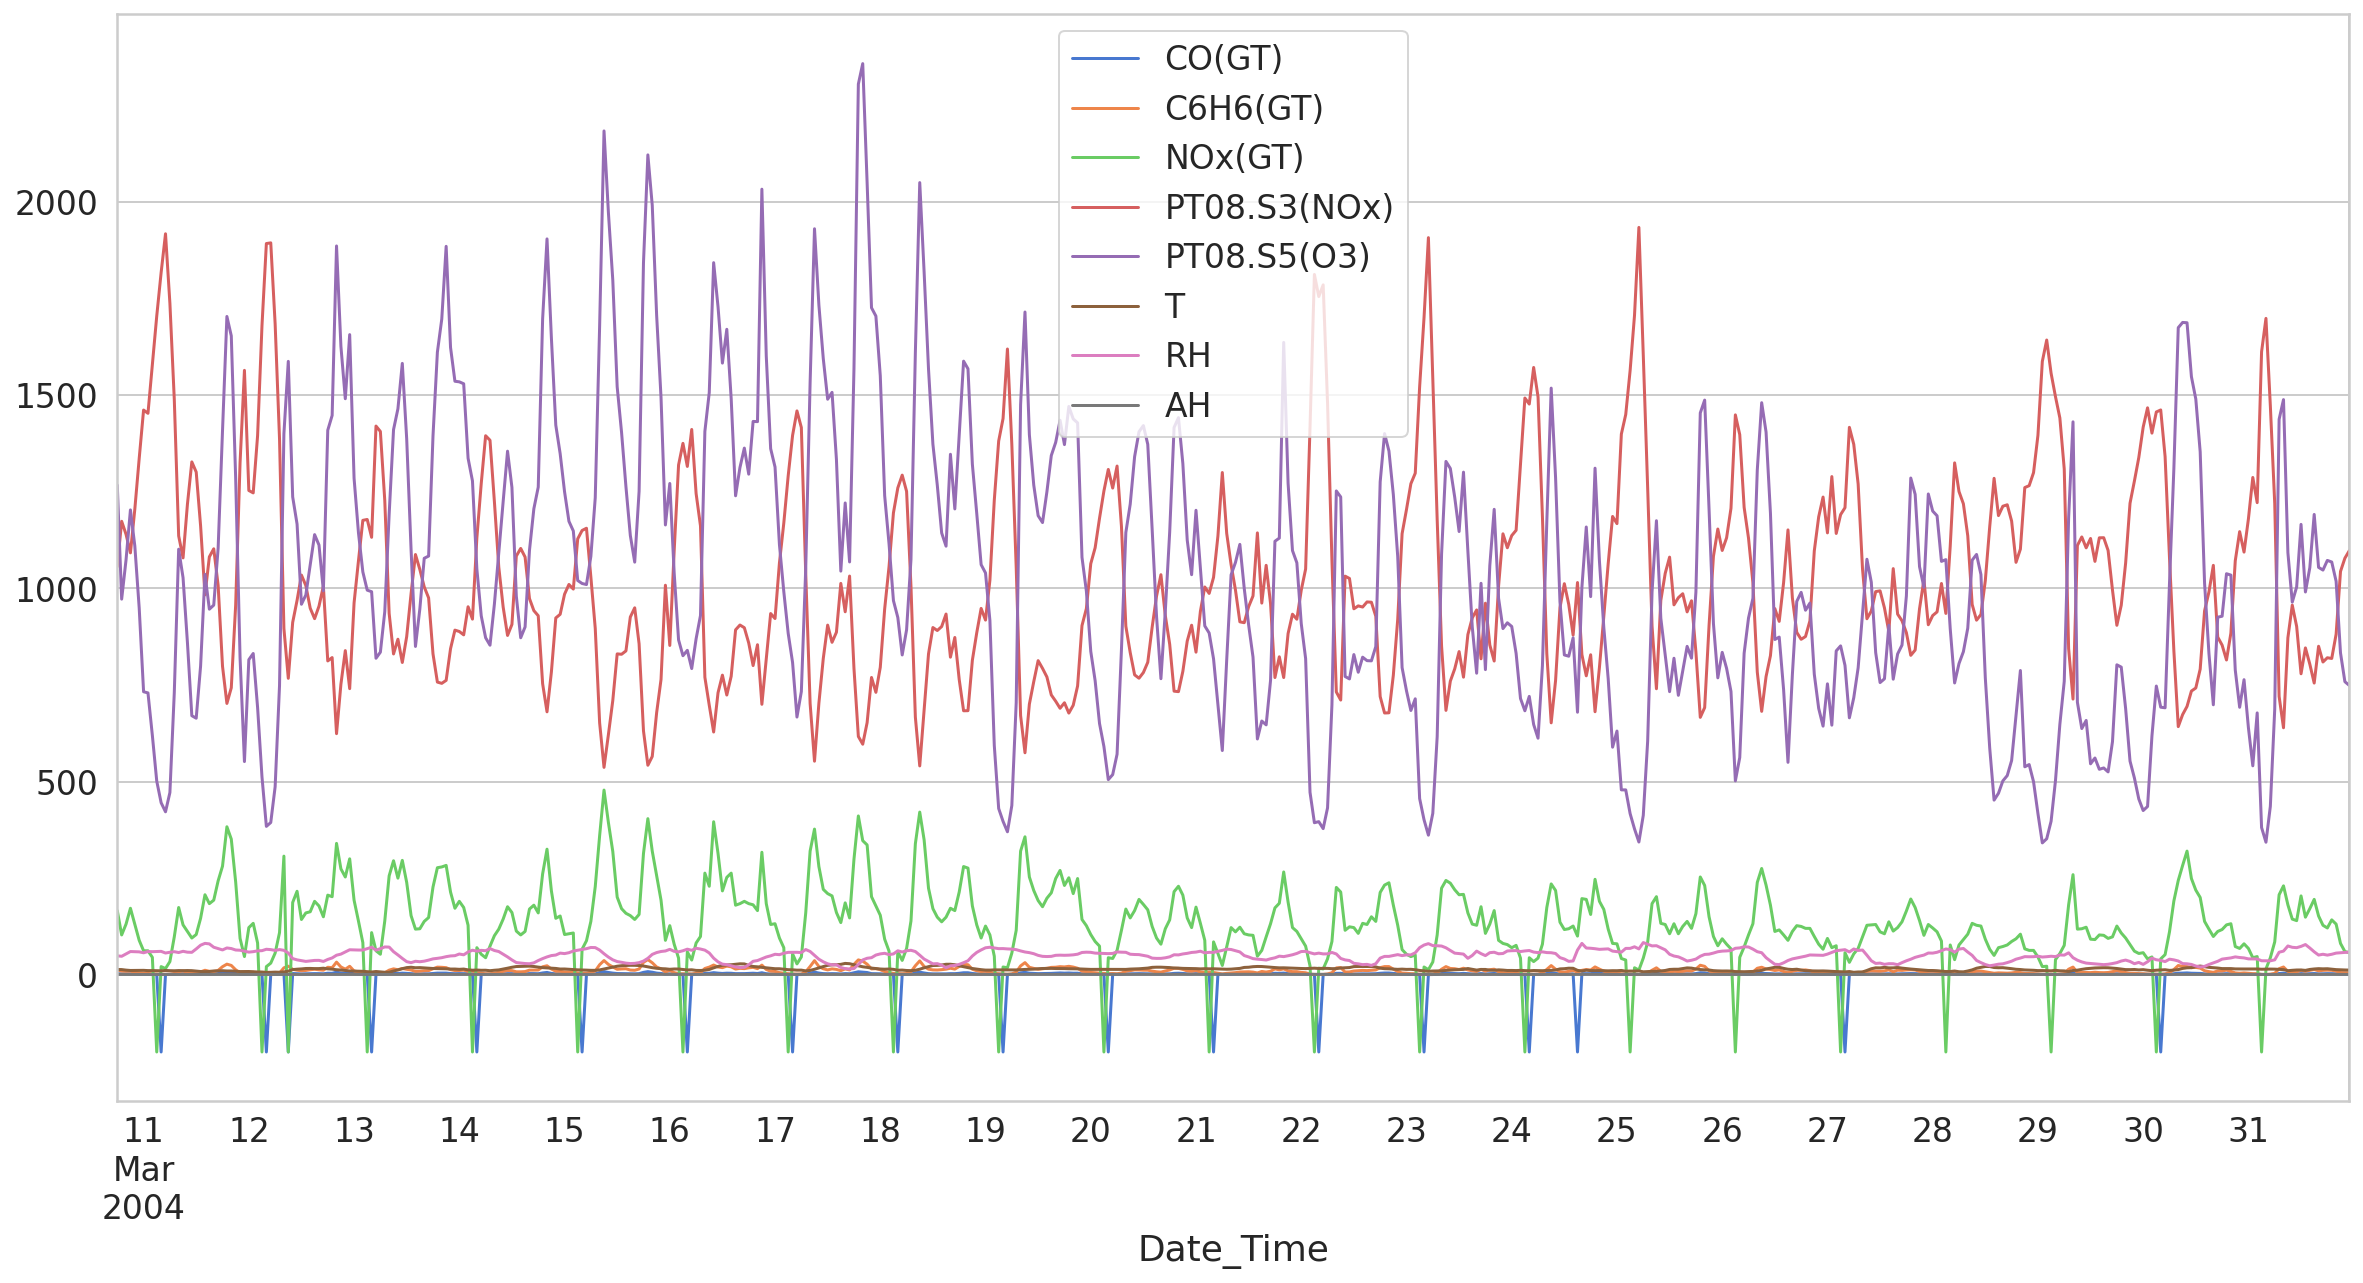

In [ ]:
#Plotting few data for one month time span to observe how it looks 
df_plot = pd.DataFrame(df_data, columns=['CO(GT)','C6H6(GT)','NOx(GT)', 'PT08.S3(NOx)','PT08.S5(O3)', 'T', 'RH', 'AH'])
df_plot.iloc[0:510].plot(y=['CO(GT)', 'C6H6(GT)','NOx(GT)', 'PT08.S3(NOx)','PT08.S5(O3)', 'T', 'RH', 'AH'])
plt.legend();

In [ ]:
#checking correlation with other columns of the dataset
df_data.corr()[["RH"]].sort_values(["RH"])

RH
NO2(GT)       -0.081300
NOx(GT)       -0.053008
CO(GT)        -0.048231
NMHC(GT)       0.008288
PT08.S5(O3)    0.524922
PT08.S3(NOx)   0.573513
PT08.S2(NMHC)  0.585775
PT08.S4(NO2)   0.640685
PT08.S1(CO)    0.745344
T              0.885910
C6H6(GT)       0.925068
AH             0.943997
RH             1.000000

In [ ]:
df_data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [ ]:
# selecting only Relative Humidity and Date column for processing
data = df_data[["RH"]]
data.columns=['Relative_Humidity']
df_newdata = pd.DataFrame(data)
df_newdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Relative_Humidity  9357 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


In [ ]:
df_newdata.head(3)

Relative_Humidity
Date_Time                             
2004-03-10 18:00:00          48.875001
2004-03-10 19:00:00          47.700000
2004-03-10 20:00:00          53.975000

Text(0, 0.5, 'Relative_Humidity')

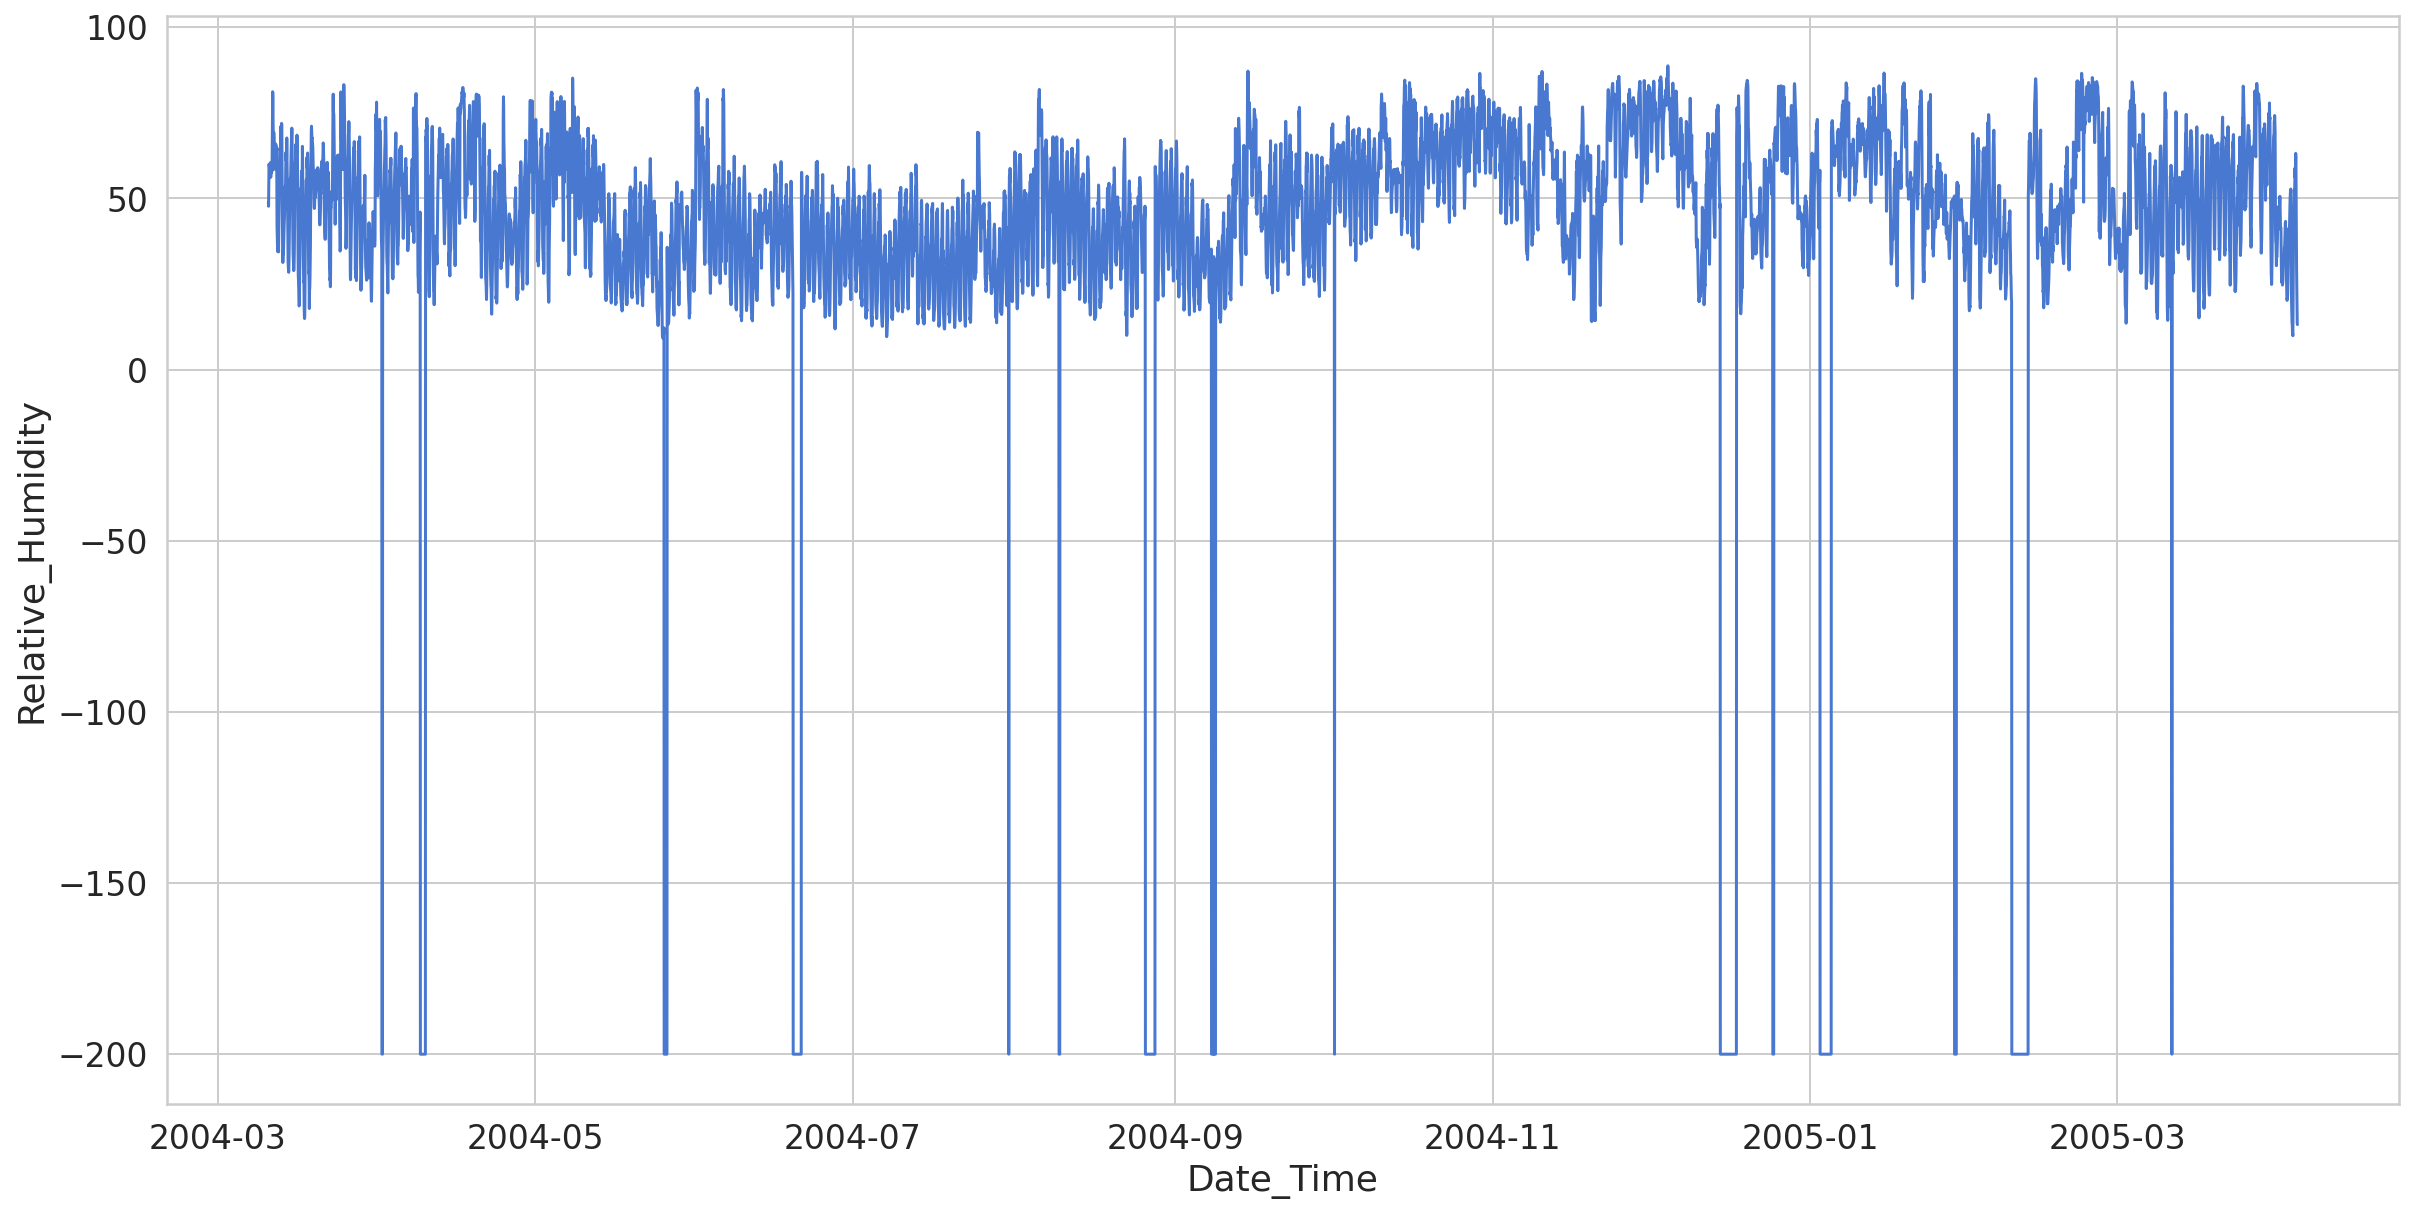

In [ ]:
#plot the current data
plt.plot(df_newdata.index, df_newdata['Relative_Humidity'])
plt.xlabel('Date_Time')
plt.ylabel('Relative_Humidity')

In [ ]:
len(df_newdata['Relative_Humidity'])

9357

In [ ]:
#Replace all missing values indicated as -200 with previous values
cols = df_newdata.columns
count_miss = 0
for i in range(0,len(df_newdata)-1):
  if df_newdata['Relative_Humidity'][i] == -200:
    df_newdata['Relative_Humidity'][i] = df_newdata['Relative_Humidity'][i-1]
    count_miss = count_miss + 1
print("Counter_Missing: ", count_miss) 
print("Length after imputation: ", len(df_newdata['Relative_Humidity']))
df_newdata.info()

Counter_Missing:  366
Length after imputation:  9357
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Relative_Humidity  9357 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


Text(0, 0.5, 'Relative_Humidity')

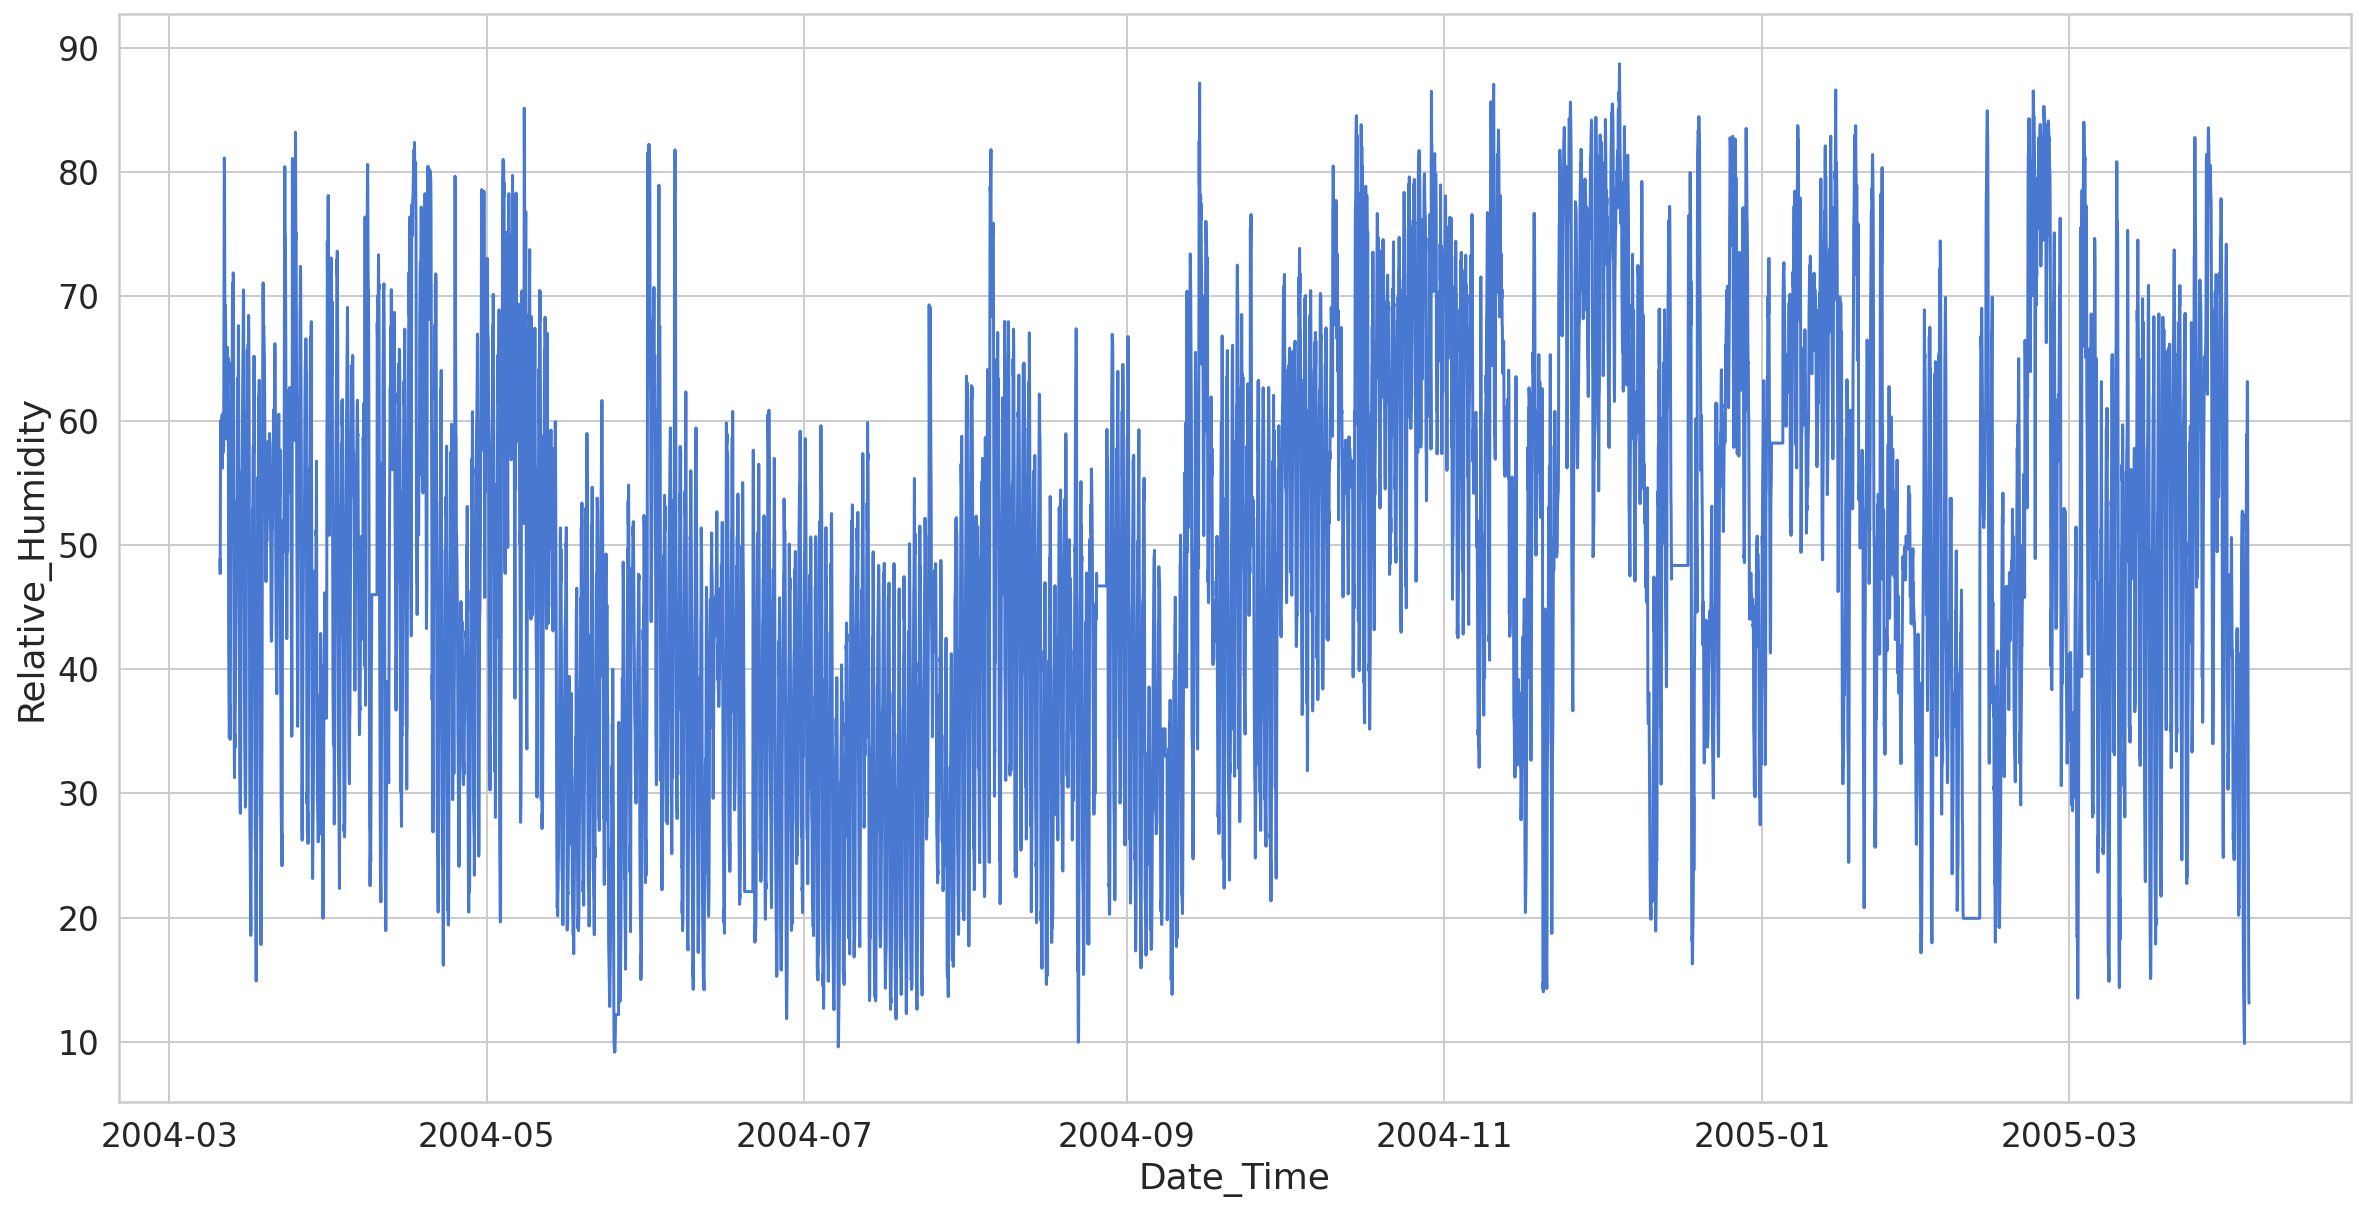

In [ ]:
# Plot again to see the data imputation in success
plt.plot(df_newdata.index, df_newdata['Relative_Humidity'])
plt.xlabel('Date_Time')
plt.ylabel('Relative_Humidity')

In [ ]:
df_newdata.head(5)

Relative_Humidity
Date_Time                             
2004-03-10 18:00:00          48.875001
2004-03-10 19:00:00          47.700000
2004-03-10 20:00:00          53.975000
2004-03-10 21:00:00          60.000000
2004-03-10 22:00:00          59.575001

In [ ]:
len(df_newdata)

9357

#**Anomaly Detection starts here**

###1) **Statistical Model** Time Series Anomaly Detection - **ARIMA**

In [ ]:
# AUGMENTED DICKY FULLER TEST(ADF) to check stationarity of the time series data
def stationarity_check(data):
  stationarity = adfuller(data)
  print('ADF Statistic: {}'.format(stationarity[0]))
  print('p-value: {}'.format(stationarity[1]))
  print('Critical Values:')
  for key, value in stationarity[4].items():
      print('\t{}: {}'.format(key, value))

#Current values
stationarity_check(df_newdata['Relative_Humidity'])

ADF Statistic: -7.317408747917467
p-value: 1.2190229463372742e-10
Critical Values:
	1%: -3.431051985659412
	5%: -2.8618502334031457
	10%: -2.5669351321592124


The data is not completely stationary as the p-value is higher than 0.05. But ADF status is comparitively good according to critical value.

In [ ]:
# Use rolling mean to make the input data stationary
rolling_mean = df_newdata.rolling(window=12).mean()
df_newdata_mean = df_newdata - rolling_mean
df_newdata_mean.fillna(method='bfill',inplace=True)

stationarity_check(df_newdata_mean)

ADF Statistic: -22.73514952866637
p-value: 0.0
Critical Values:
	1%: -3.431051834977192
	5%: -2.8618501668189706
	10%: -2.5669350967161857


In [ ]:
# Use time shift to make the input data stationary
df_newdata_shift = df_newdata - df_newdata.shift()
df_newdata_shift.fillna(method='bfill',inplace=True)

stationarity_check(df_newdata_shift)

ADF Statistic: -20.254763927269387
p-value: 0.0
Critical Values:
	1%: -3.431051985659412
	5%: -2.8618502334031457
	10%: -2.5669351321592124


Text(0, 0.5, 'Relative_Humidity')

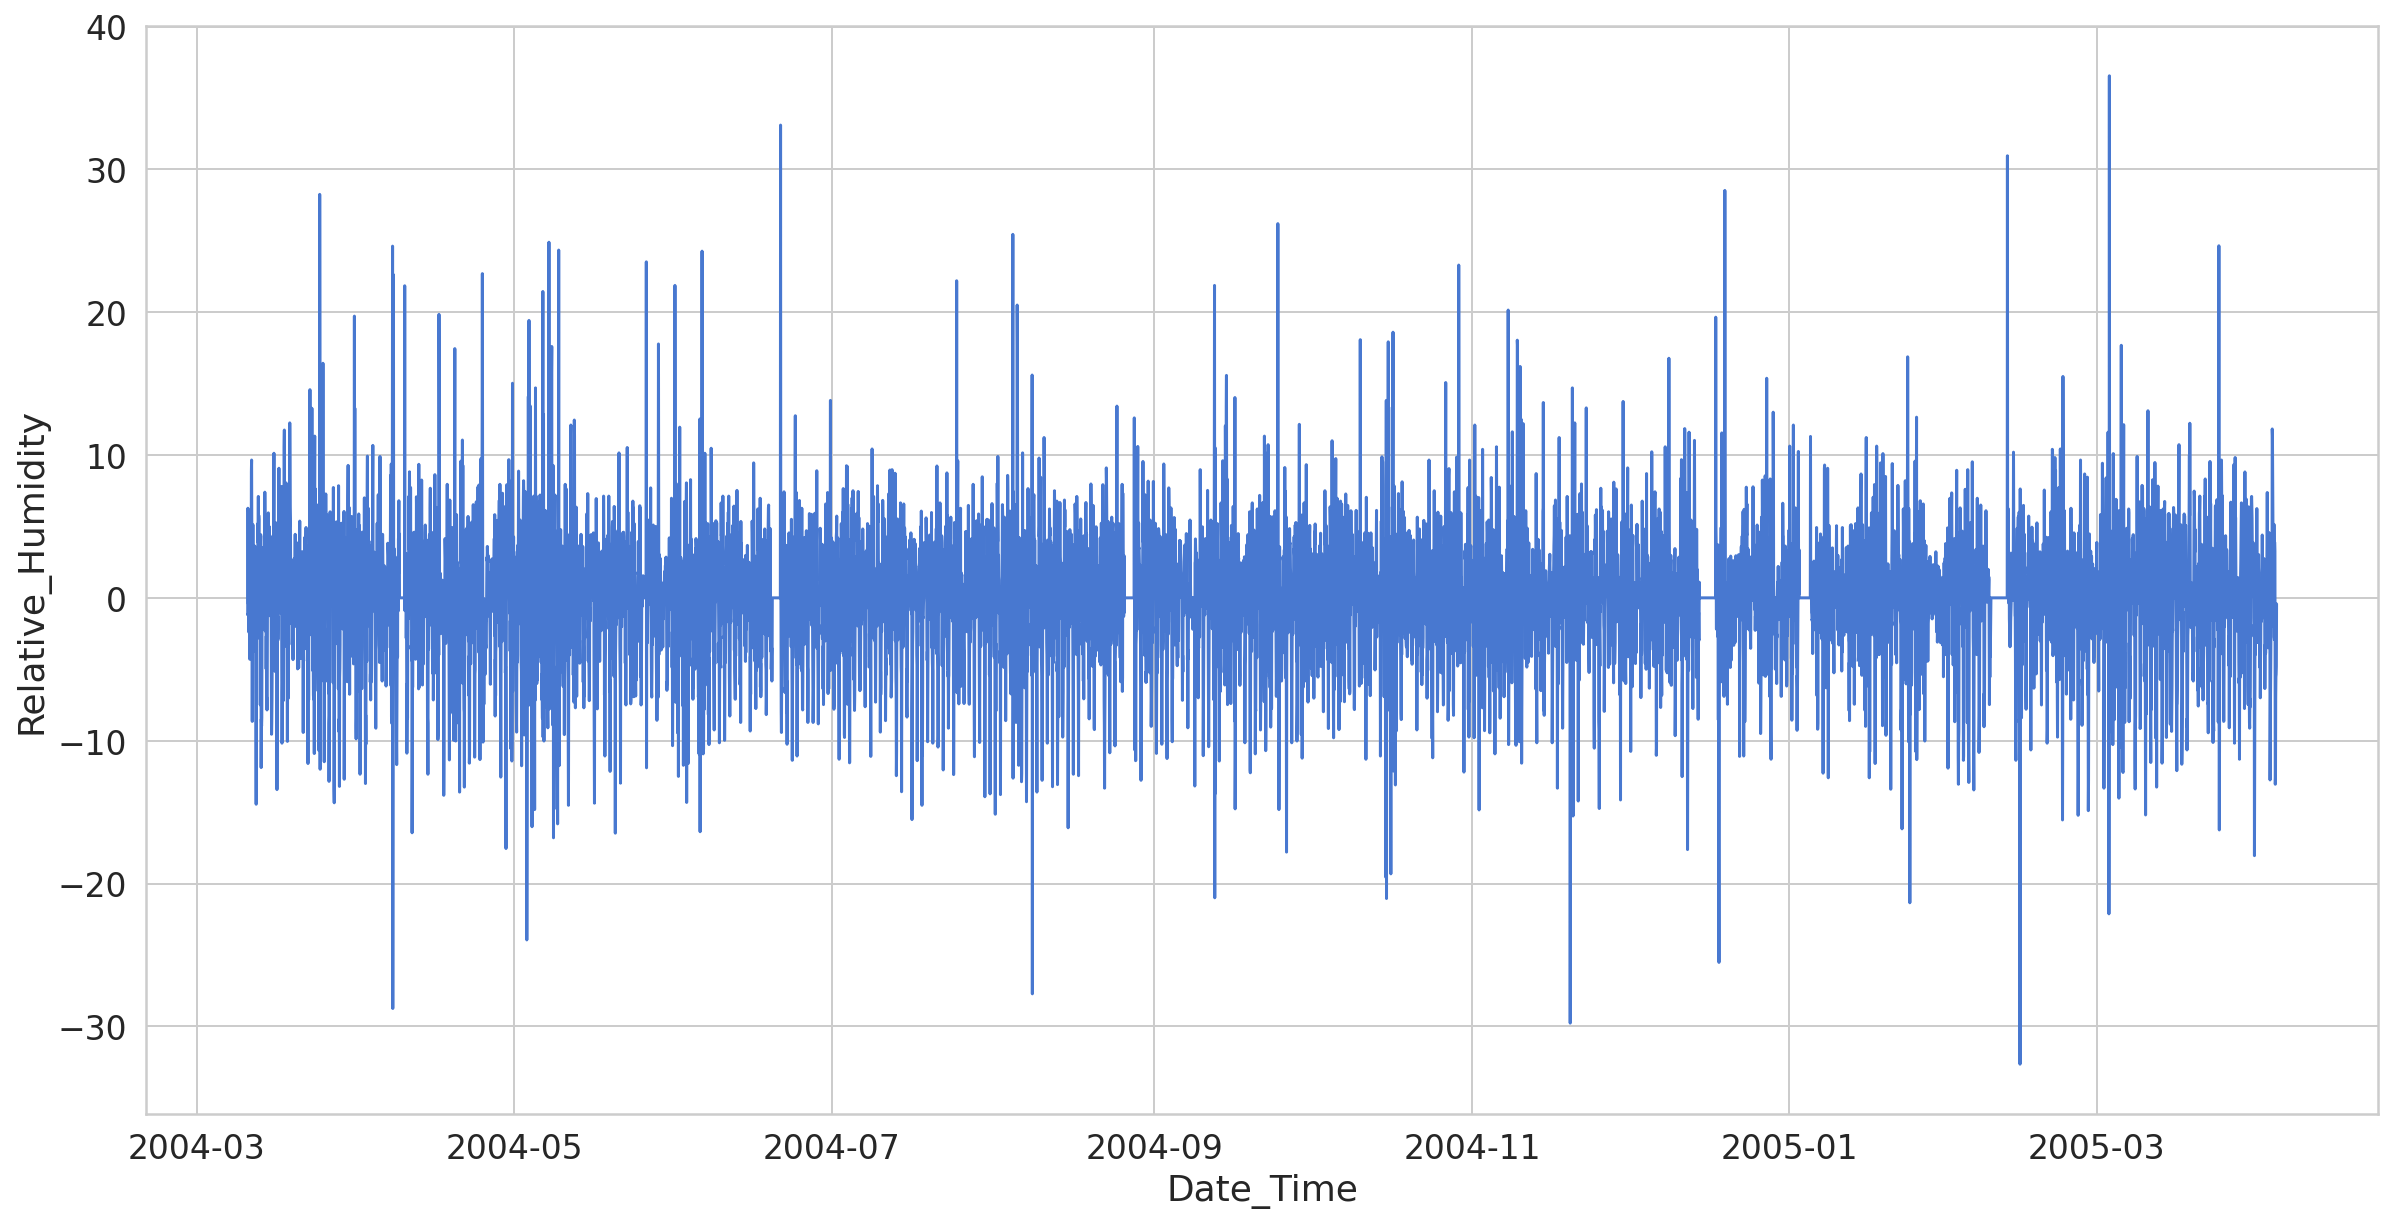

In [ ]:
# Plot again to see the data imputation in success
plt.plot(df_newdata_shift.index, df_newdata_shift['Relative_Humidity'])
plt.xlabel('Date_Time')
plt.ylabel('Relative_Humidity')

In [ ]:
size = int(len(df_newdata_shift) * 0.85)
X_train_arima= df_newdata_shift[:size]
y_test_arima = df_newdata_shift[size:]

print('length of train data: ', len(X_train_arima))
print('length of test data: ', len(y_test_arima))

length of train data:  7953
length of test data:  1404


In [ ]:
#Forecasting to measure accuracy of ARIMA model
model_arima_train = ARIMA(X_train_arima.Relative_Humidity, order=(2,0,1))
model_arima_fit_train = model_arima_train.fit()

model_arima_fit_train.predict(start=int(len(df_newdata_shift)), end=int(len(df_newdata_shift)))
pred_forecast=model_arima_fit_train.forecast(steps=len(y_test_arima))[0]
#pred_forecast
mae = np.mean(np.abs(pred_forecast - y_test_arima['Relative_Humidity'].values)) 
print("Mean absolute error,ARIMA : ", mae)

Mean absolute error,ARIMA :  3.343347672557643


In [ ]:
# Anomaly detection for all data ARIMA
model_arima = ARIMA(df_newdata_shift.Relative_Humidity, order=(2,0,1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.007     -0.205      0.837      -0.015       0.013
ar.L1          1.3547      0.007    203.593      0.000       1.342       1.368
ar.L2         -0.4323      0.006    -70.998      0.000      -0.444      -0.420
ma.L1         -0.9875      0.002   -527.590      0.000      -0.991      -0.984
sigma2        16.8138      0.126    132.944      0.000      16.566      17.062


In [ ]:
len(model_arima_fit.fittedvalues)

9357

In [ ]:
#Use squared errors to find the anomalies
def detect_outliers(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors) * 1.3
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [ ]:
squared_errors = model_arima_fit.resid ** 2
predictions, threshold = detect_outliers(squared_errors)

In [ ]:
threshold

84.3496777034387

In [ ]:
anomalies = pd.DataFrame(predictions)
anomalies.rename(columns = {0:'Relative_Humidity'}, inplace = True)
anomalies = anomalies[~(anomalies == 0).any(axis=1)]
anomalies

Relative_Humidity
Date_Time                             
2004-03-12 10:00:00                  1
2004-03-13 09:00:00                  1
2004-03-16 10:00:00                  1
2004-03-18 21:00:00                  1
2004-03-22 09:00:00                  1
...                                ...
2005-03-29 12:00:00                  1
2005-03-31 08:00:00                  1
2005-04-03 08:00:00                  1
2005-04-03 18:00:00                  1
2005-04-04 08:00:00                  1

[345 rows x 1 columns]

In [ ]:
anomalies_values = anomalies.merge(df_newdata_shift[["Relative_Humidity"]], on="Date_Time", how="left")
anomalies_values.head(3)

Relative_Humidity_x  Relative_Humidity_y
Date_Time                                                    
2004-03-12 10:00:00                    1           -14.450000
2004-03-13 09:00:00                    1           -11.883333
2004-03-16 10:00:00                    1           -13.424999

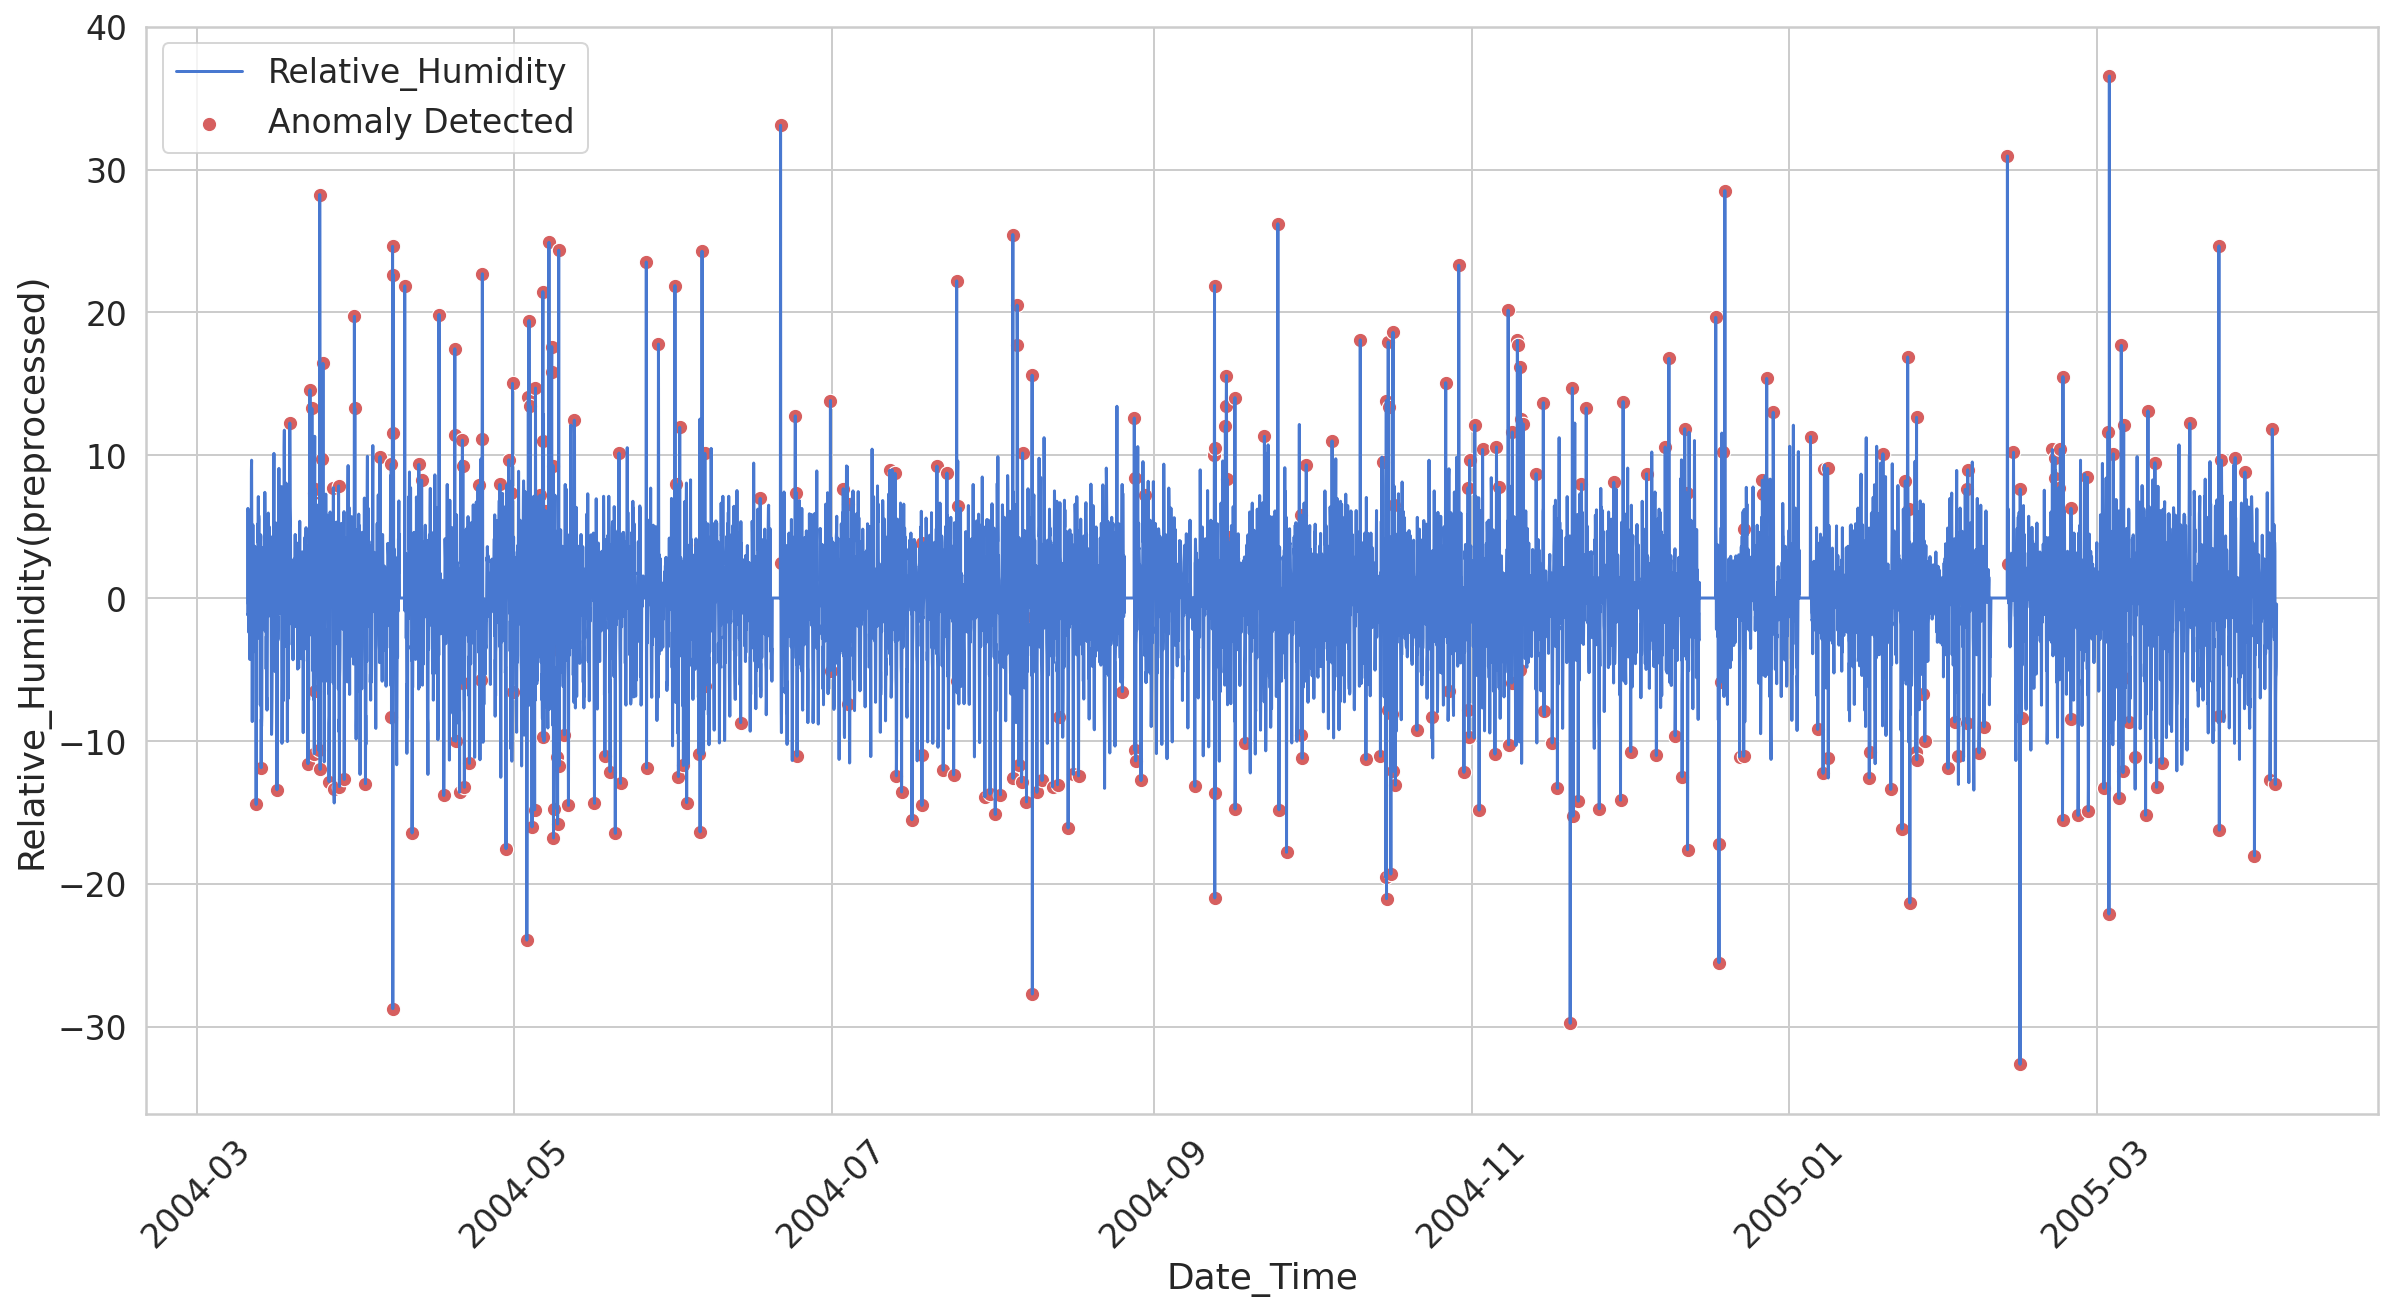

In [ ]:
plt.plot(df_newdata_shift.index, df_newdata_shift['Relative_Humidity'],label='Relative_Humidity');

sns.scatterplot(anomalies_values.index, anomalies_values['Relative_Humidity_y'],
                color=sns.color_palette()[3],s=52,label='anomaly')
plt.xticks(rotation=45)
plt.legend(['Relative_Humidity', 'Anomaly Detected'])
plt.ylabel('Relative_Humidity(preprocessed)')
plt.xlabel('Date_Time');

###2) **Predictive Model** Time Series Anomaly Detection - **LSTM**

In [ ]:
X, y = train_test_split(df_newdata, test_size = 0.33, shuffle=False, random_state = RANDOM_SEED)
X_t = X.copy()
y_t = y.copy()
print(X.shape, y.shape)
print(X_t.shape, y_t.shape)

(6269, 1) (3088, 1)
(6269, 1) (3088, 1)


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_newdata[['Relative_Humidity']])

X['Relative_Humidity'] = scaler.transform(X[['Relative_Humidity']])
y['Relative_Humidity'] = scaler.transform(y[['Relative_Humidity']])

Text(0, 0.5, 'Relative_Humidity')

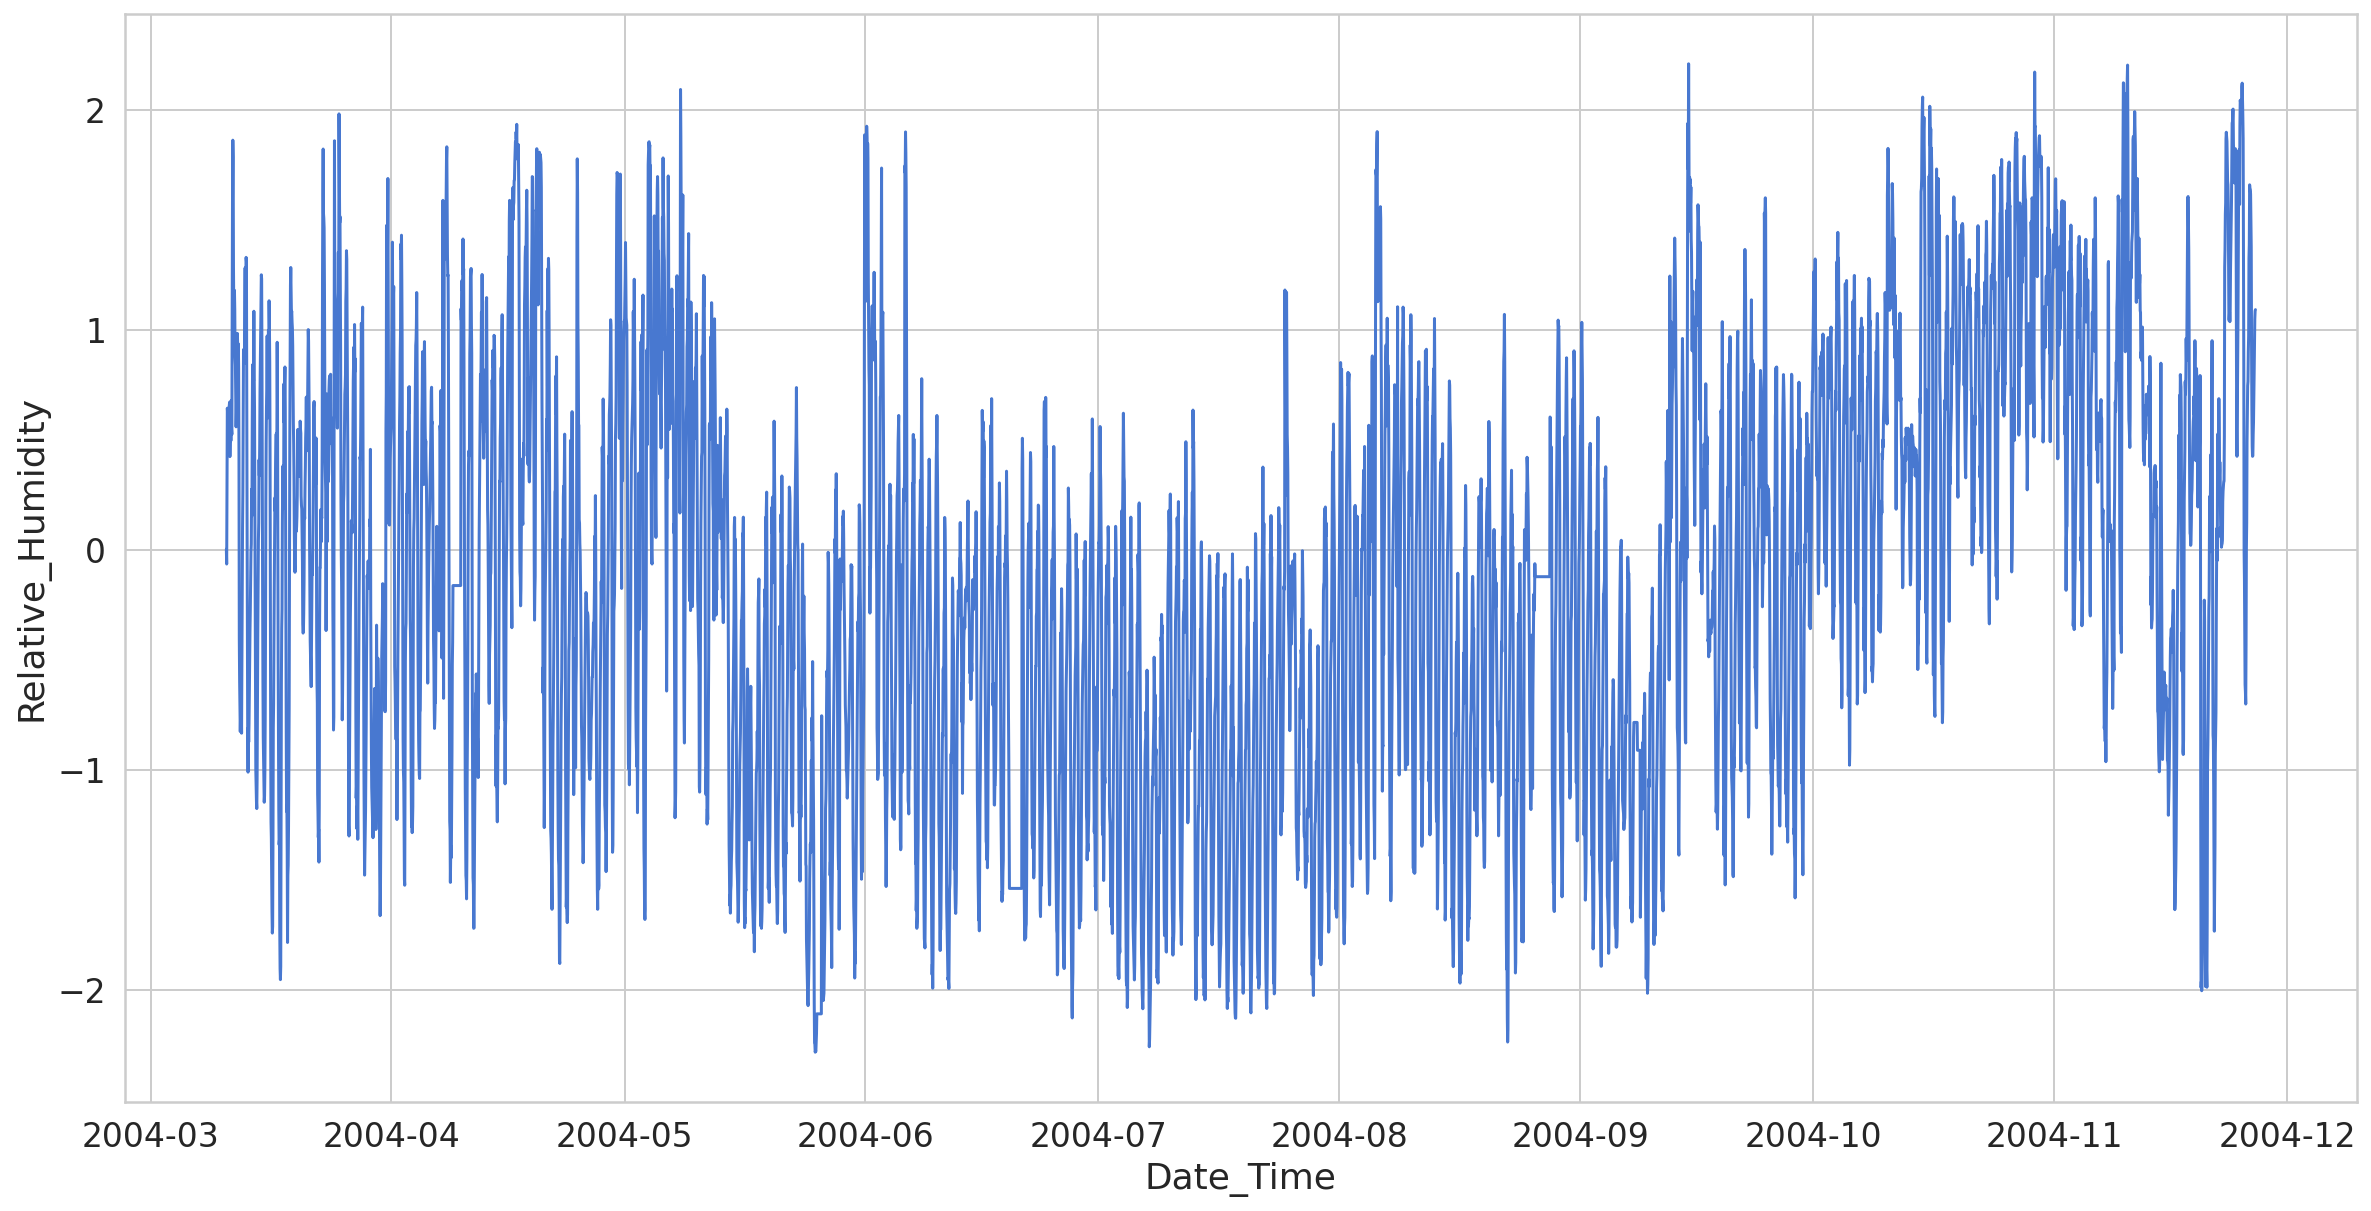

In [ ]:
# Plot the train data to see the standardization is success
plt.plot(X.index, X['Relative_Humidity'])
plt.xlabel('Date_Time')
plt.ylabel('Relative_Humidity')

Text(0, 0.5, 'Relative_Humidity')

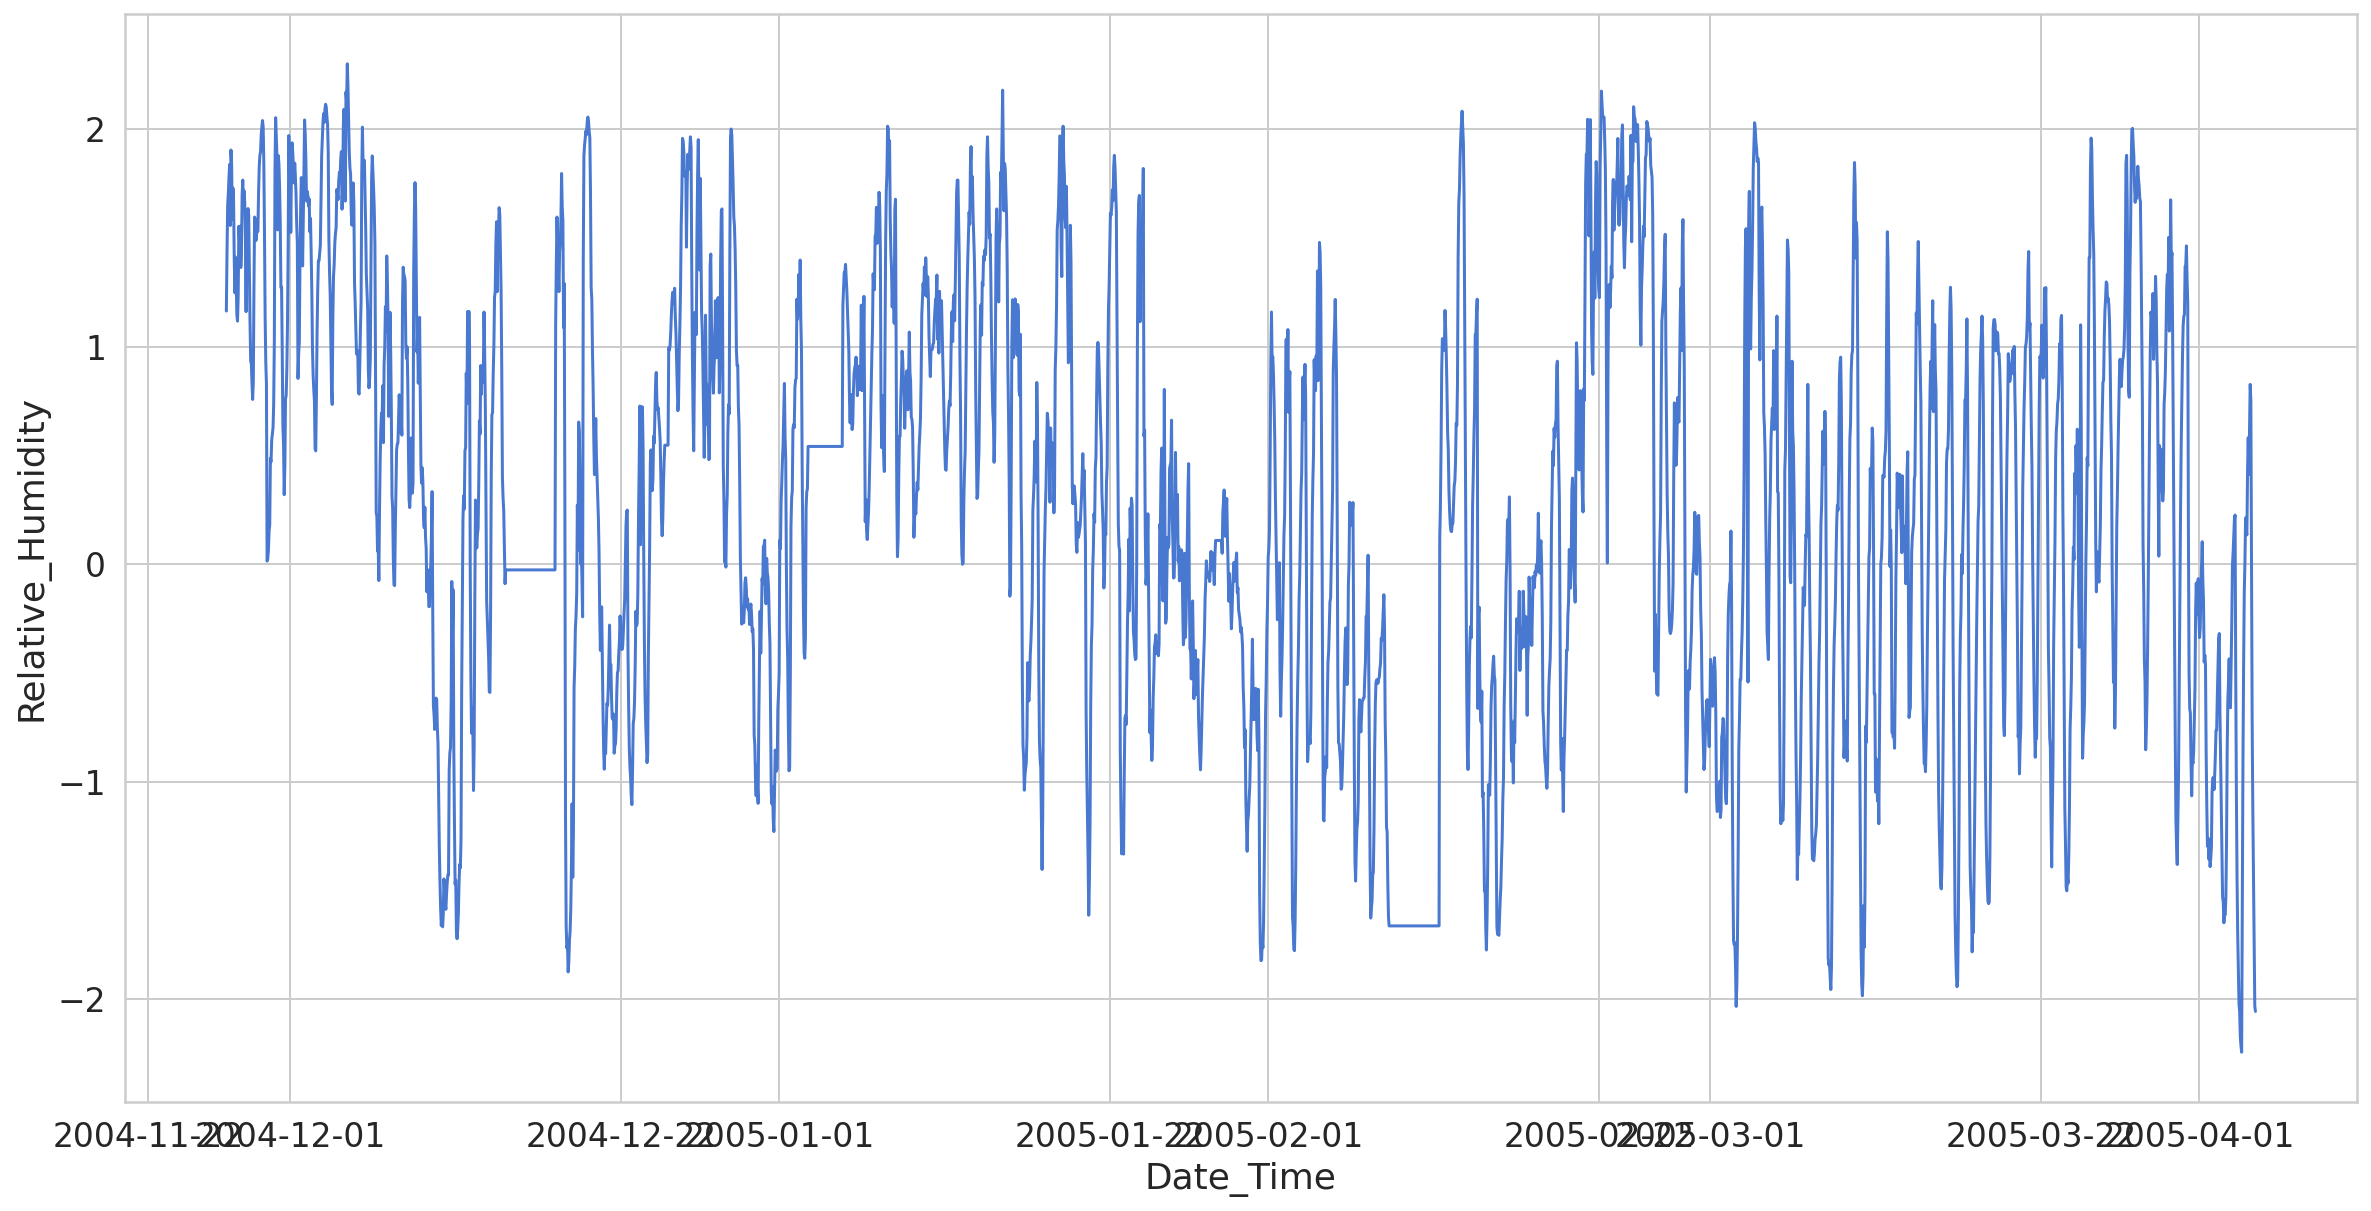

In [ ]:
# Plot the test data to see the standardization is success
plt.plot(y.index, y['Relative_Humidity'])
plt.xlabel('Date_Time')
plt.ylabel('Relative_Humidity')

In [ ]:
def create_dataset(X, y, steps=1):
    Xs, ys = [], []
    for i in range(len(X) - steps):
        v = X.iloc[i:(i + steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 10

# reshape the data as needed 

X_train, y_train = create_dataset(X[['Relative_Humidity']], X.Relative_Humidity, TIME_STEPS)
X_test, y_test = create_dataset(y[['Relative_Humidity']], y.Relative_Humidity, TIME_STEPS)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6259, 10, 1) (3078, 10, 1) (6259,) (3078,)


In [ ]:
#creating a LSTM based model
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units = 64, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.3,shuffle=False)

Epoch 1/10
137/137 [==============================] - 6s 19ms/step - loss: 0.6843 - val_loss: 0.6996
Epoch 2/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6801 - val_loss: 0.7038
Epoch 3/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6770 - val_loss: 0.6929
Epoch 4/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6744 - val_loss: 0.6857
Epoch 5/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6720 - val_loss: 0.6873
Epoch 6/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6701 - val_loss: 0.6744
Epoch 7/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6683 - val_loss: 0.6762
Epoch 8/10
137/137 [==============================] - 2s 13ms/step - loss: 0.6671 - val_loss: 0.6655
Epoch 9/10
137/137 [==============================] - 2s 14ms/step - loss: 0.6659 - val_loss: 0.6642
Epoch 10/10
137/137 [==============================] - 2s 14ms/step - loss: 0.6638 - val_lo

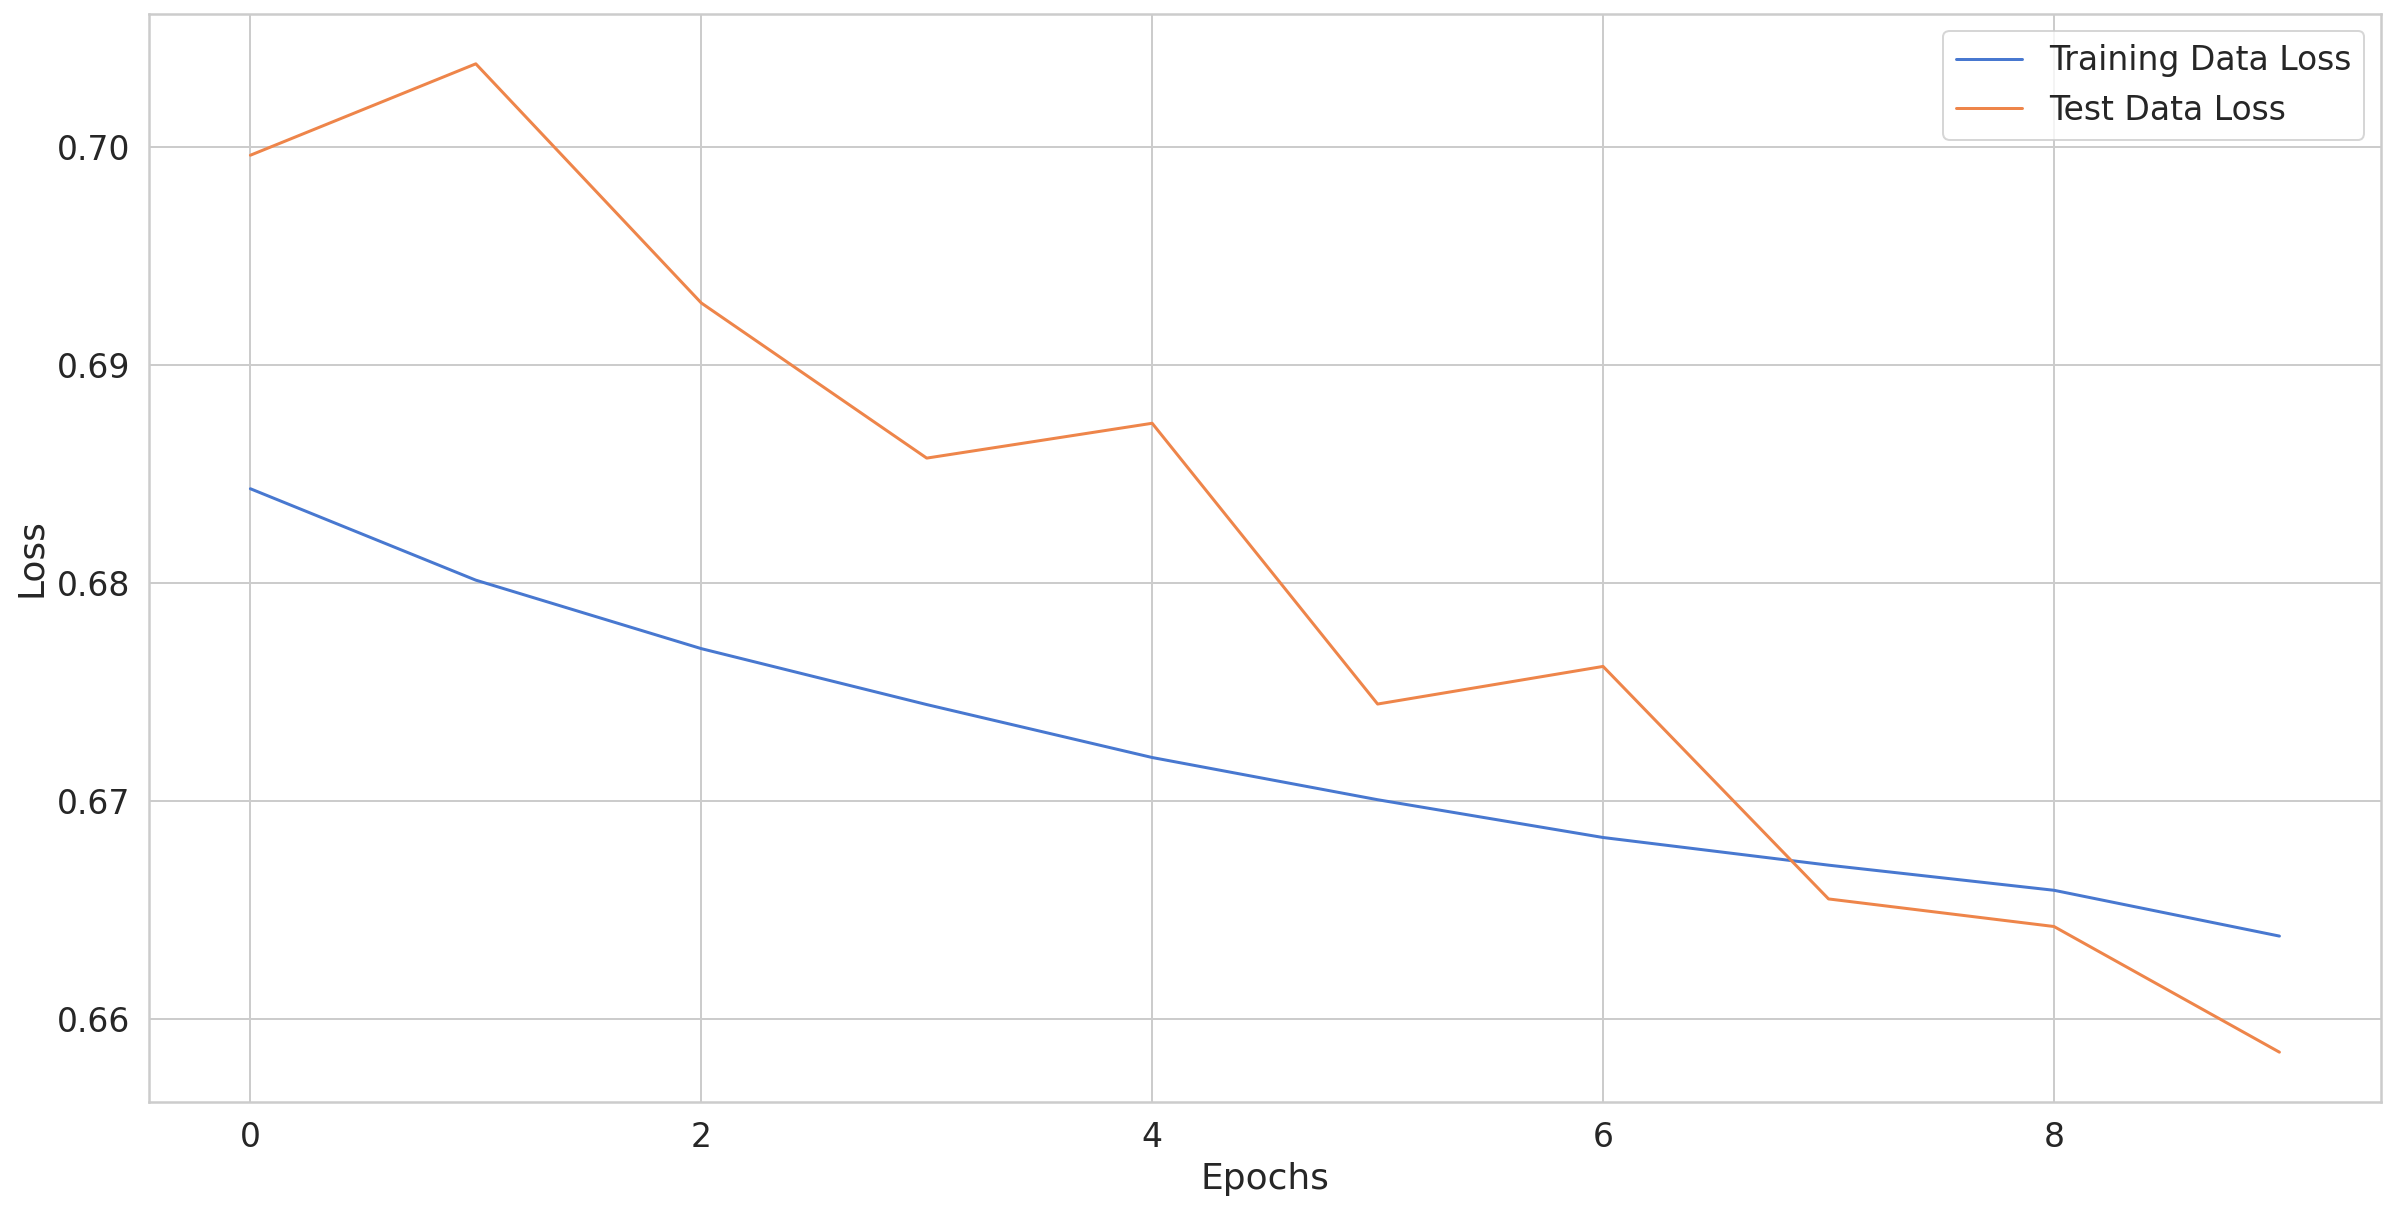

In [ ]:
plt.plot(history.history['loss'], label='Training Data Loss')
plt.plot(history.history['val_loss'], label='Test Data Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis= 1)
print("Mean absolute error: LSTM ", np.max(test_mae_loss) )

97/97 [==============================] - 0s 4ms/step
Mean absolute error: LSTM  1.489787785498214


In [ ]:
threshold = np.max(train_mae_loss) - 0.3
print(f'Threshold: {threshold}')

test_score_df = pd.DataFrame(y[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Relative_Humidity'] = y[TIME_STEPS:].Relative_Humidity

Threshold: 1.0782168198295923


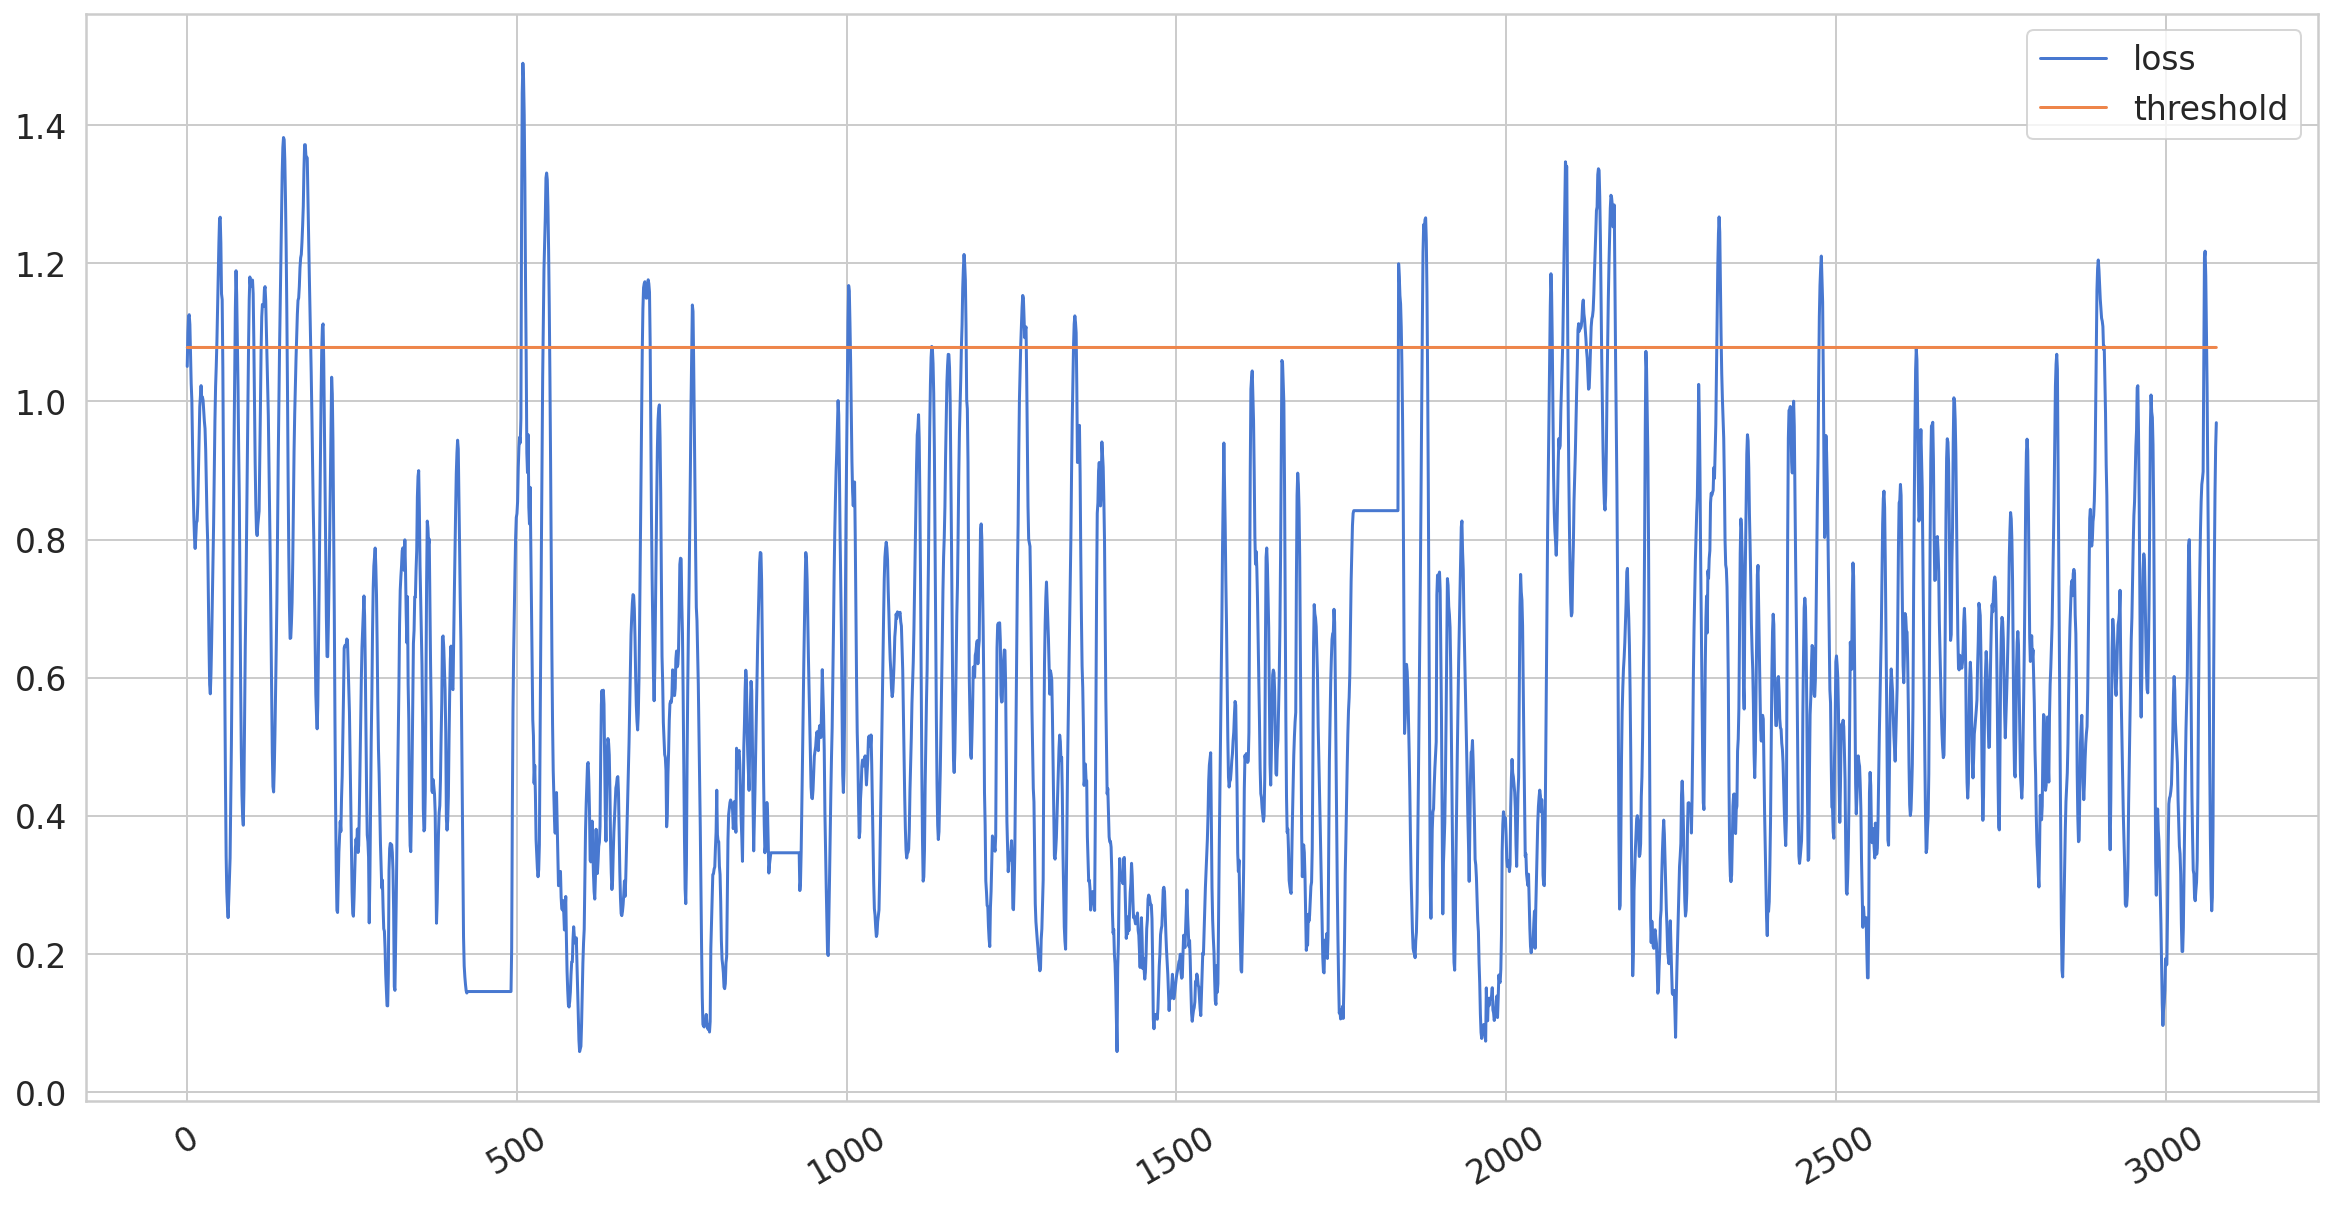

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=30)
plt.legend();

In [ ]:
anomalie = test_score_df[test_score_df.anomaly == True]

In [ ]:
anomalie_values = anomalie.merge(y[["Relative_Humidity"]], on="Date_Time", how="left")
anomalie_values.rename(columns = {'Relative_Humidity_y':'Relative_Humidity'}, inplace = True)

In [ ]:
anomalie_values.head()

Date_Time      loss  threshold  anomaly  Relative_Humidity_x  \
0 2004-11-27 10:00:00  1.099661   1.078217     True                  NaN   
1 2004-11-27 11:00:00  1.123045   1.078217     True                  NaN   
2 2004-11-27 12:00:00  1.125650   1.078217     True                  NaN   
3 2004-11-27 13:00:00  1.111426   1.078217     True                  NaN   
4 2004-11-29 06:00:00  1.086354   1.078217     True                  NaN   

   Relative_Humidity  
0           1.671711  
1           1.403755  
2           1.246726  
3           1.410958  
4           2.039071

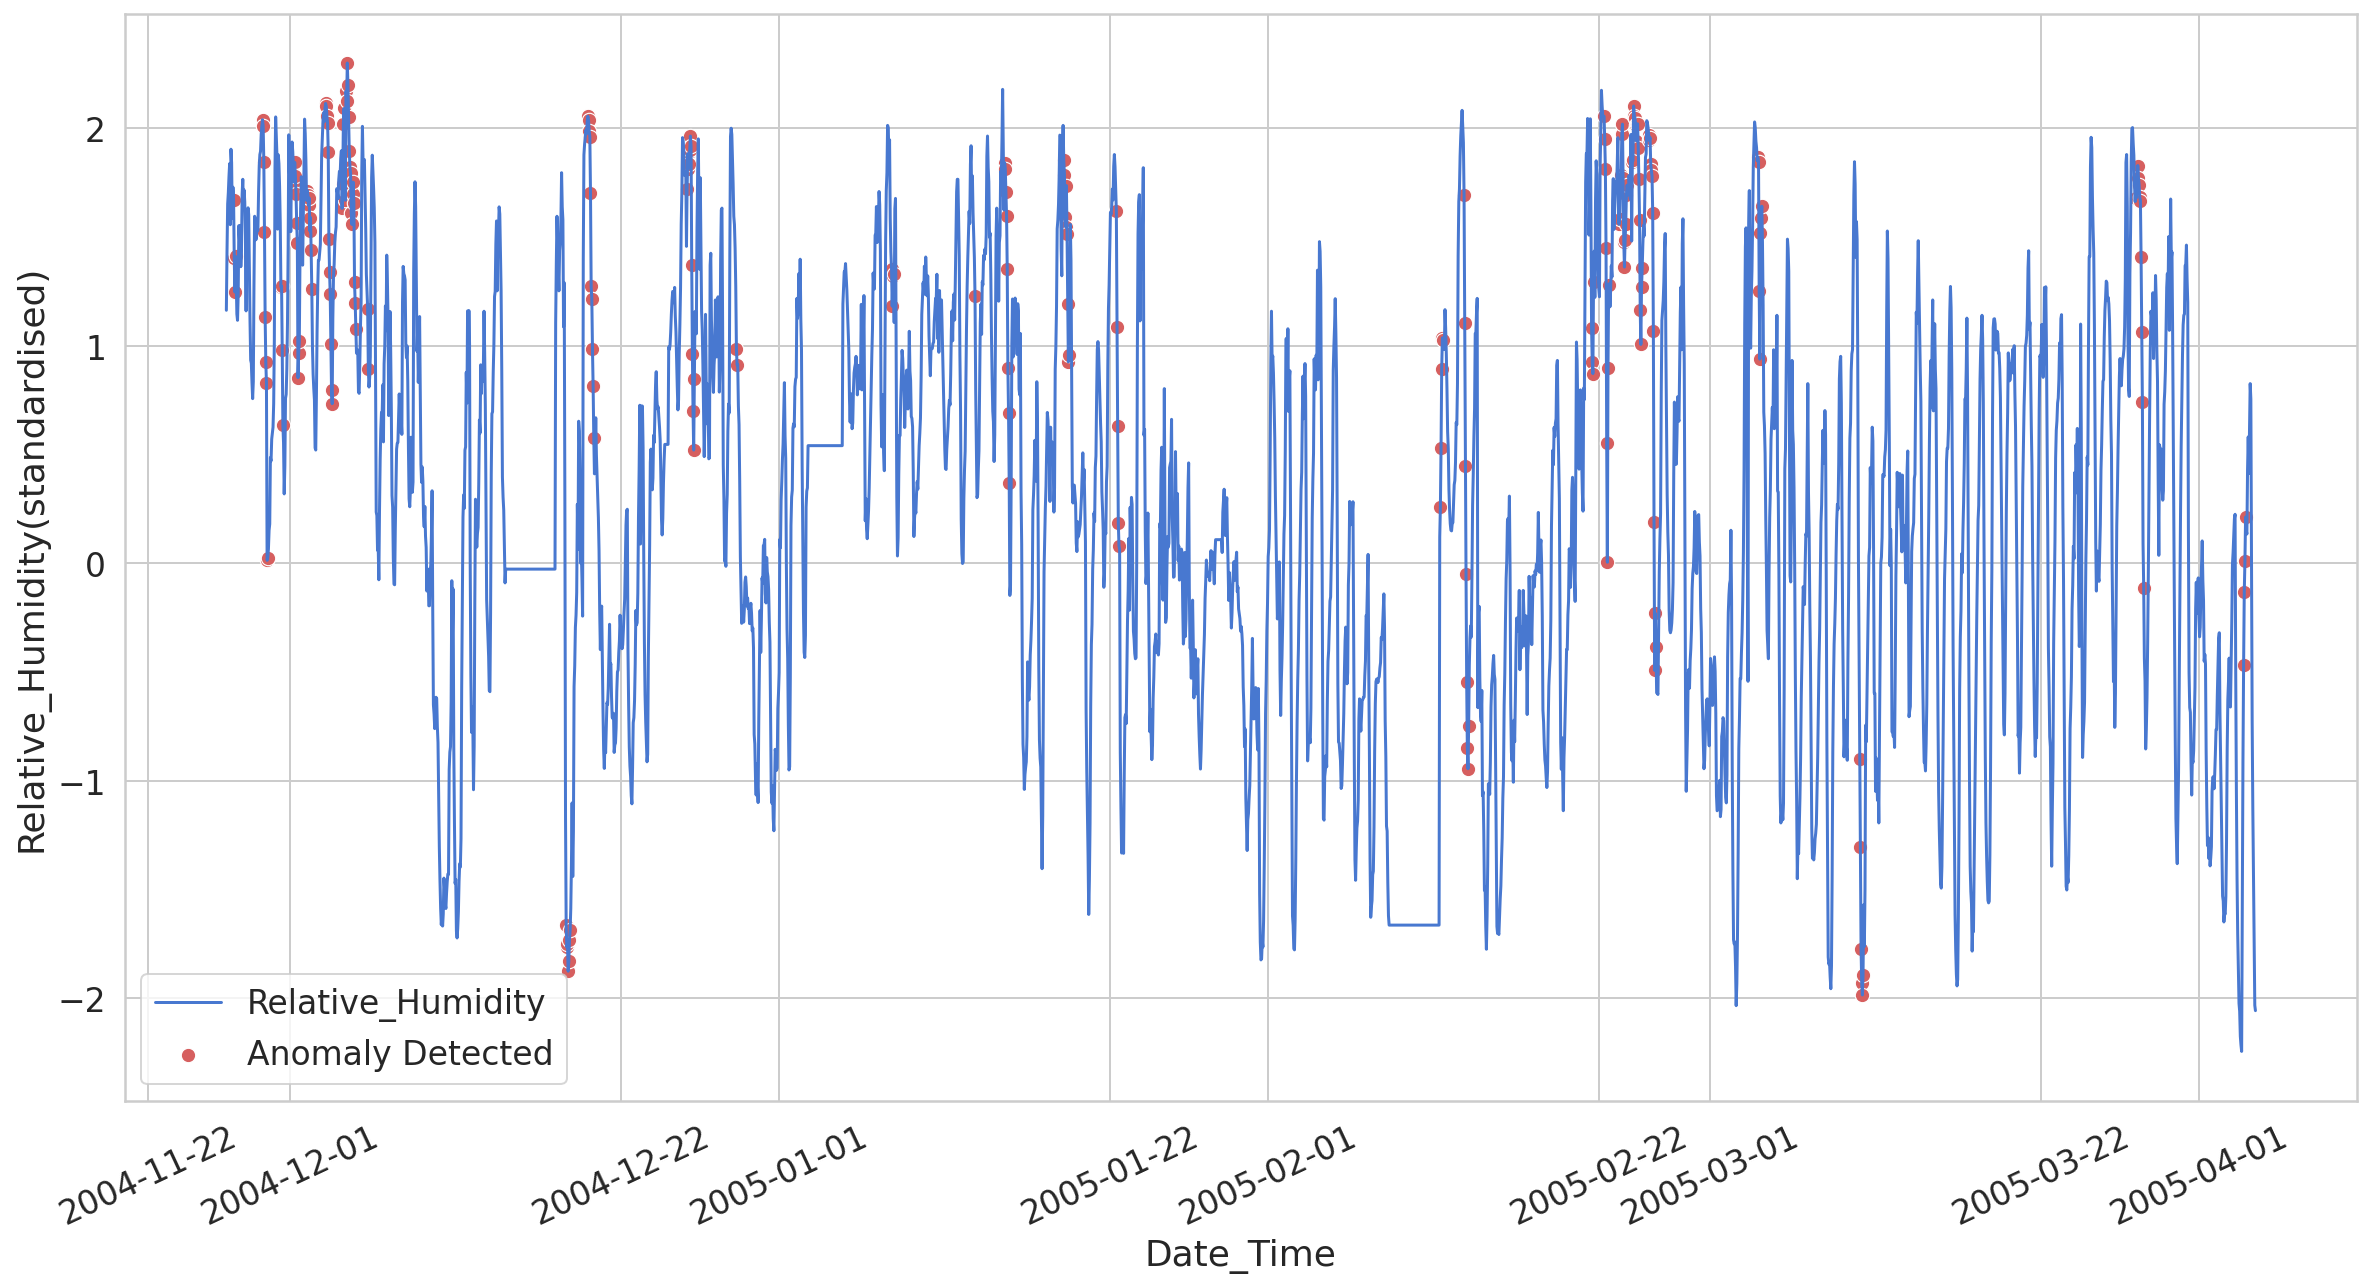

In [ ]:
plt.plot(y.index, y.Relative_Humidity,label='Relative_Humidity');

sns.scatterplot(anomalie_values.Date_Time,
  anomalie_values.Relative_Humidity,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend(['Relative_Humidity', 'Anomaly Detected'])
plt.ylabel('Relative_Humidity(standardised)')
plt.xlabel('Date_Time');

###3) **Clustering Model** Time Series Anomaly Detection - **DBSCAN**

In [ ]:
# Clustering DBSCAN
model_dbscan = DBSCAN(eps=0.09, min_samples=15)
model_dbscan_fit = model_dbscan.fit(np.array(df_newdata['Relative_Humidity']).reshape(-1,1))
labels = model_dbscan_fit.labels_

#Assign non-clustered points as anomalies
anomalies_pos = np.where(labels == -1)[0]

In [ ]:
print('Length of the labels: ', len(labels))
print(labels)
print('Number of anomalies: ', len(anomalies_pos))
print('Positions: ', anomalies_pos)

Length of the labels:  9357
[ 0  0  0 ... -1 -1 -1]
Number of anomalies:  529
Positions:  [  20  166  167  168  189  298  302  348  350  679  681  891  892  894
  895  897  924  926  965  967  972 1029 1030 1051 1085 1206 1304 1333
 1366 1403 1410 1556 1724 1792 1794 1795 1796 1797 1798 1799 1800 1816
 1817 1818 1819 1820 1821 1822 1823 1843 1844 1845 1846 1847 1870 1940
 1941 1943 1972 1973 1978 2098 2099 2156 2157 2158 2179 2180 2181 2182
 2183 2205 2227 2228 2229 2230 2231 2232 2469 2470 2544 2567 2568 2586
 2587 2588 2589 2611 2612 2613 2614 2615 2634 2734 2754 2755 2756 2757
 2758 2759 2780 2781 2782 2783 2784 2803 2804 2805 2806 2828 2829 2830
 2831 2832 2848 2850 2851 2852 2853 2854 2855 2874 2875 2876 2877 2878
 2879 2898 2924 2925 2950 2994 2995 2996 2999 3018 3019 3020 3021 3022
 3023 3024 3025 3044 3045 3046 3067 3068 3069 3070 3071 3072 3073 3090
 3091 3092 3093 3094 3095 3113 3114 3115 3117 3118 3119 3120 3138 3139
 3140 3141 3142 3163 3164 3166 3167 3185 3186 3187 3188 31

In [ ]:
df_newdata.reset_index(inplace=True)
df_newdata.head(2)

Date_Time  Relative_Humidity
0 2004-03-10 18:00:00          48.875001
1 2004-03-10 19:00:00          47.700000

In [ ]:
df_anomalies = pd.DataFrame(df_newdata.iloc[anomalies_pos])
df_anomalies.head(3)

Date_Time  Relative_Humidity
20  2004-03-11 14:00:00              81.15
166 2004-03-17 16:00:00              15.75
167 2004-03-17 17:00:00              14.90

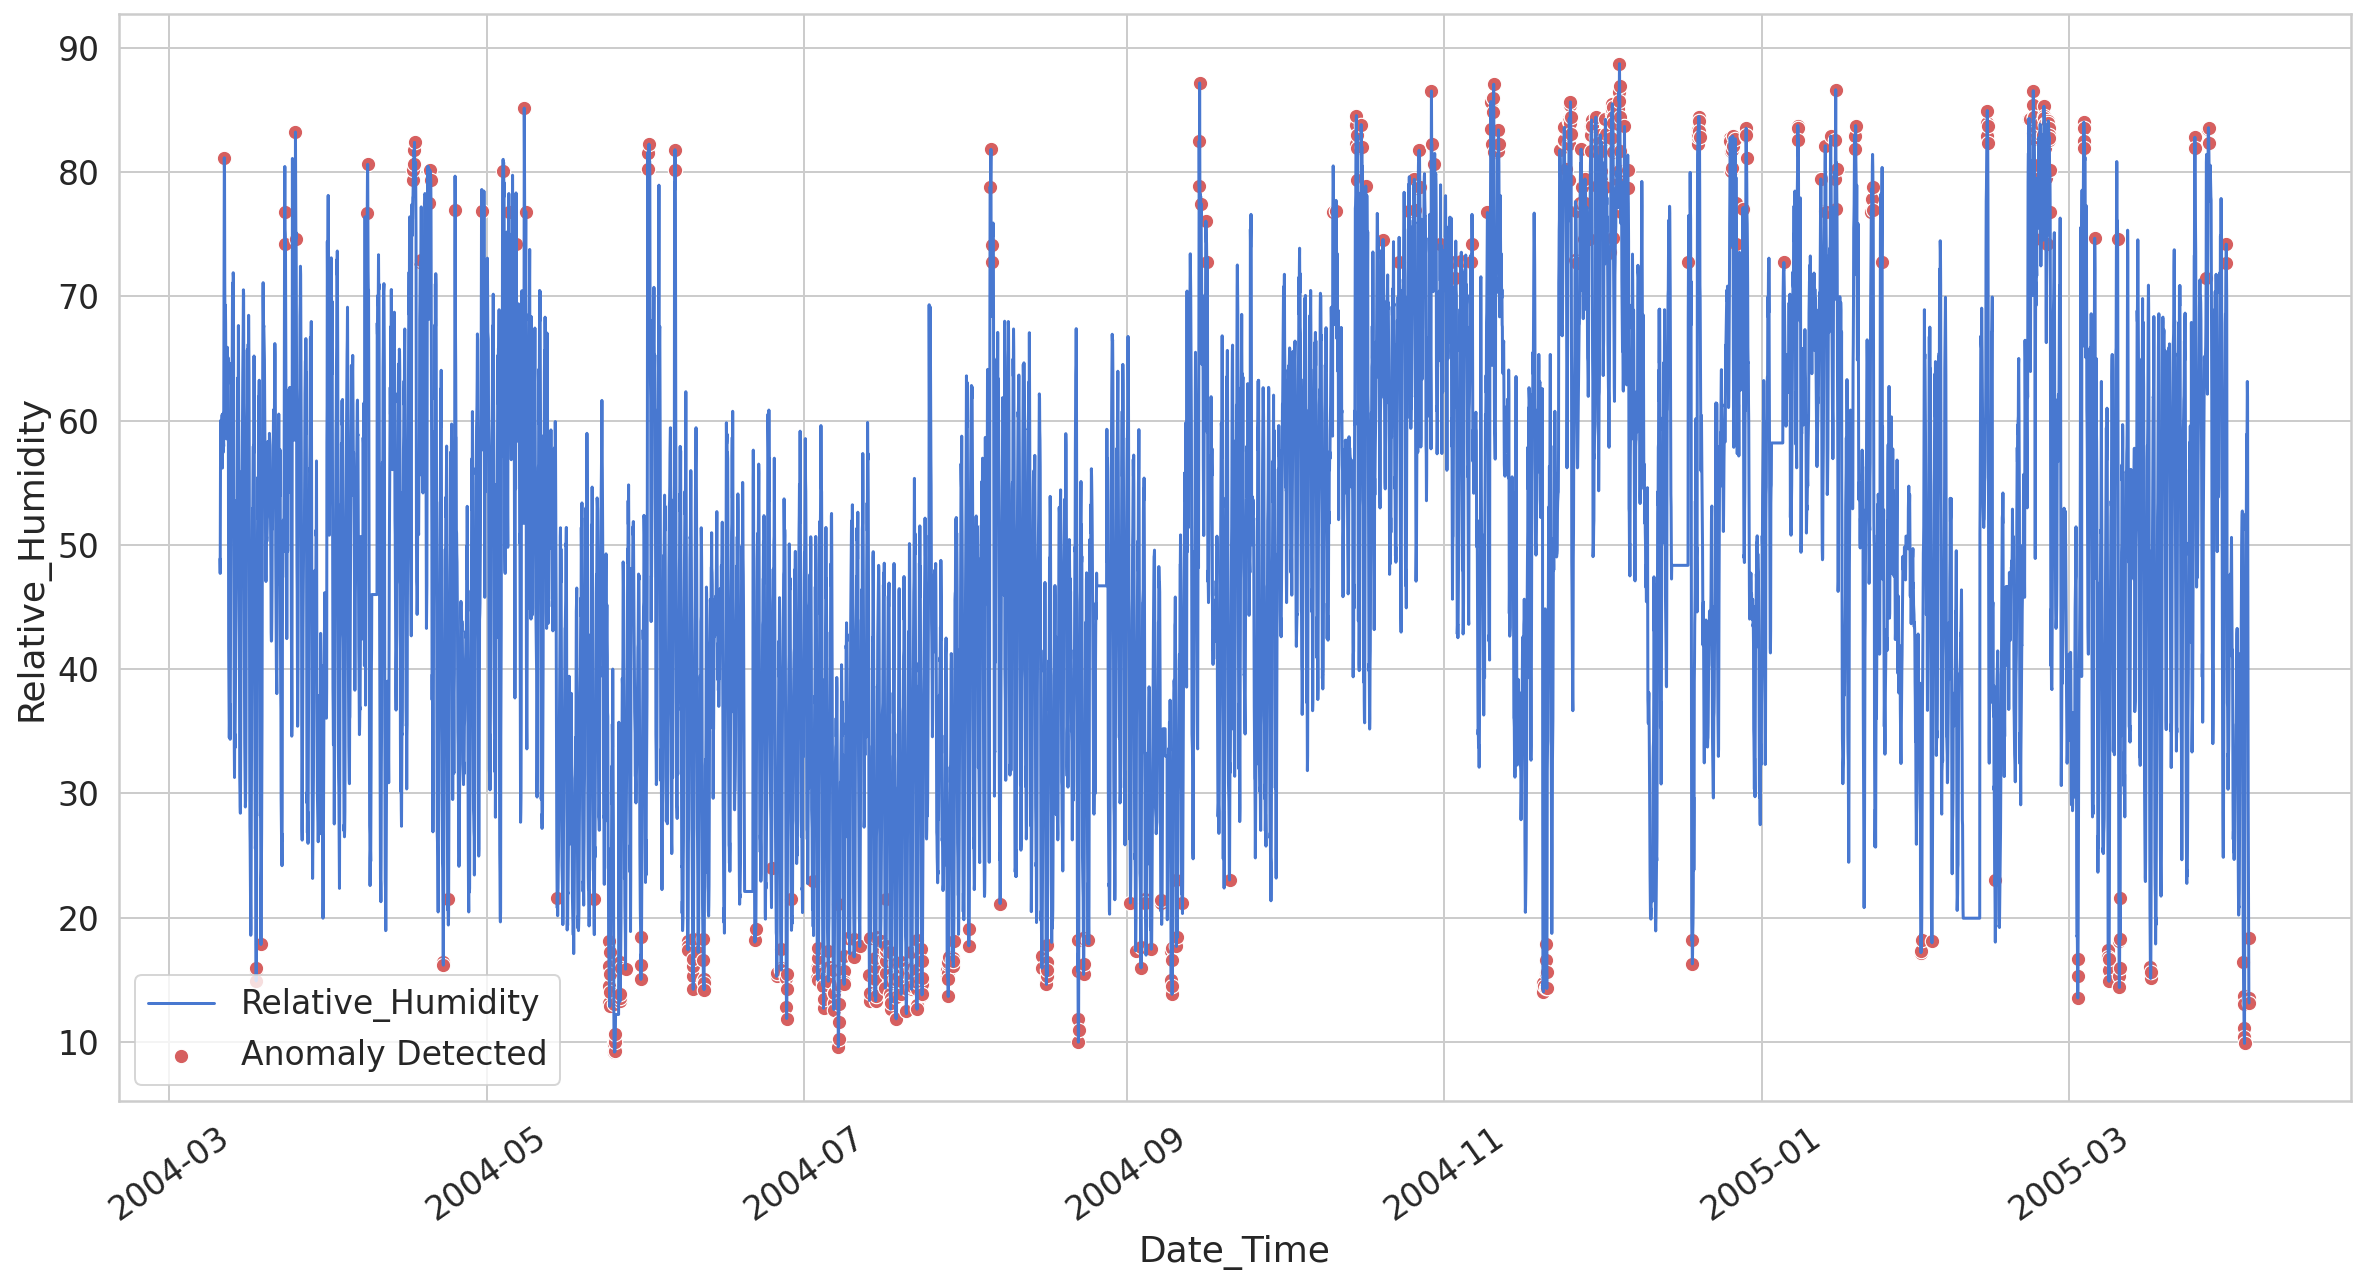

In [ ]:
#Plotting

plt.plot(
  df_newdata.Date_Time, 
  df_newdata.Relative_Humidity,
  label='Relative_Humidity'
);

sns.scatterplot(
  df_anomalies.Date_Time,
  df_anomalies.Relative_Humidity,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=35)
plt.legend(['Relative_Humidity', 'Anomaly Detected'])
plt.ylabel('Relative_Humidity')
plt.xlabel('Date_Time');